## Importing and installing need libraries

In [1]:
import numpy as np
from tensorflow.keras import Model as Model_
from tensorflow.keras.layers import Input, ReLU, LSTM, GRU, SimpleRNN, Dense, TimeDistributed, Bidirectional, GaussianNoise 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from itertools import chain
import tensorflow_model_remediation.min_diff.losses.mmd_loss as MMD

print(tf.__version__)

2.9.0


## Dataset Reading and Preprocessing

### Listing all the movable joints in the human skeleton

In [2]:
#Was done in the preprocessing in [1]
# Joints in H3.6M -- data has 32 joints, but only 17 that move; these are the indices.
H36M_NAMES = ['']*32
H36M_NAMES[0]  = 'Hip'
H36M_NAMES[1]  = 'RHip'
H36M_NAMES[2]  = 'RKnee'
H36M_NAMES[3]  = 'RFoot'
H36M_NAMES[6]  = 'LHip'
H36M_NAMES[7]  = 'LKnee'
H36M_NAMES[8]  = 'LFoot'
H36M_NAMES[12] = 'Spine'
H36M_NAMES[13] = 'Thorax'
H36M_NAMES[14] = 'Neck/Nose'
H36M_NAMES[15] = 'Head'
H36M_NAMES[17] = 'LShoulder'
H36M_NAMES[18] = 'LElbow'
H36M_NAMES[19] = 'LWrist'
H36M_NAMES[25] = 'RShoulder'
H36M_NAMES[26] = 'RElbow'
H36M_NAMES[27] = 'RWrist'

### A class to Read and Combine all the Dataset files

In [3]:
import os
import re

class Dataset_loading:
    def __init__(self, dir_path, include_dimension = 2, sample_size = 50,
                 total_classes = 17, datatype = 'float32', include_movable_joints = False):
        
        #Dataset Directory path
        self.dir_path = dir_path
        
        #Which Dimension file to include, possible values: 2 and 3
        self.include_dimension = include_dimension
        
        #Total frames in one Sample
        self.sample_size = sample_size
        
        #Default Datatype for all the samples
        self.datatype = datatype
        
        #Activity classes to include
        self.classes = ['SittingDown', 'Walking', 'Directions', 'Discussion', 'Sitting', 'Phoning', 'Eating', 'Posing', 'Greeting', 'Smoking']
        
        #Total activity classes
        self.total_classes = len(self.classes)
        
        #Subject Folders names in the Dataset
        self.internal_folders = ['S1', 'S5','S6','S7','S8','S9','S11']

        #Boolean value indicating whether to include all joints or only the movable joints.
        self.include_movable_joints = include_movable_joints
        
        self.movable_joints = [0, 1, 2, 3, 6, 7, 8, 12, 13, 14, 15, 17, 18, 19, 25, 26, 27]
    
    def read_dataset(self):
        try:
            #Contains all the different activity vectors
            activity_vector = {}
            
            #Contains the overall dataset
            sampled_data = None
            
            #Based on dimensions, which folder to use for extracting the dataset files
            data_folder = 'Poses_D2_Positions' if self.include_dimension == 2 else 'Poses_D3_Positions'
            
            #Checking if the dataset path is valid
            if not os.path.exists(self.dir_path):
                print('The Data Directory Does not Exist!')
                return None

            #Iterating over all the subject folders
            for fld in self.internal_folders:
                #Iterating for each file in the specified folder
                for file in os.listdir(os.path.join(self.dir_path, fld, data_folder)):
                    #Extracting the activity from the filename
                    activity = self.__extract_activity(file)
                    
                    if activity not in self.classes:
                        continue
                    
                    #Reading the CSV file using Pandas
                    data = pd.read_csv(os.path.join(self.dir_path, fld, data_folder, file), header=None)

                    #Formulating the activity vector using one hot encoding
                    if activity not in activity_vector:
                        total_keys = len(activity_vector.keys())
                        activity_vector[activity] = np.zeros(self.total_classes)
                        activity_vector[activity][total_keys] = 1
                    vector = activity_vector[activity]
                    
                    #Sampling the dataset
                    grouped_sample = self.__group_samples(data, self.sample_size, vector)
                    sampled_data = grouped_sample if sampled_data is None else np.append(sampled_data, grouped_sample, axis=0)
            
            #Changing the Datatype
            sampled_data = sampled_data.astype(self.datatype)
            
            return sampled_data
        except Exception as e:
            print(e)
    
    def __extract_activity(self, filename):
        try:
            #Extracting the filename and excluding the extension
            name = os.path.splitext(filename)[0]
            
            #Substituting the empty string with characters other than english alphabets
            activity = re.sub('[^A-Za-z]+' , '' , name)
            return activity
        except Exception as e:
            print(e)
    
    def __group_samples(self, dataset, sample_size, activity):
        try:
            #Checking if the dataset is a Pandas Dataframe
            if not isinstance(dataset, pd.DataFrame):
                print('Expecting Pandas Dataframe, but got {}'.format(type(dataset)))
                return None
            
            if self.include_movable_joints:
                joints = list(chain.from_iterable((jt*2, (jt*2)+1) for jt in self.movable_joints))
                dataset = dataset.iloc[: , joints].copy()

            #Appending activity class to each row in the dataset
            dataset = pd.concat([dataset, pd.DataFrame(np.tile(activity, (dataset.shape[0],1)))], axis=1)
            
            #Reshaping the dataset into sample batches
            total_samples = dataset.shape[0]//sample_size
            total_features = dataset.shape[1]
            grouped_rows = dataset.to_numpy()[:total_samples*self.sample_size].reshape((-1,self.sample_size, total_features))
            
            return grouped_rows
        except Exception as e:
            print(e)

### A function to split Dataset into Features and Labels

In [4]:
def split_to_features_labels(dataset, input_sequance_size=10, total_features=64) :
    """
    Function for splitting the data into features(with sequance size=iput_sequance_size)
    and labels which should be the remainder of the sample length 
    """
    assert input_sequance_size < dataset.shape[1], f"input sequance should be smaller than the total sample size"
    features = dataset[:, np.s_[0:input_sequance_size], :]
    labels = dataset[:,np.s_[input_sequance_size:], :total_features]
    
    return features, labels

### A function for downsampling the dataset on number of frames

In [5]:
def downsampling(sampled_data, downsample_technique = 'skip'):
    """
    The function used to down-sample the data using two different techniques. In Skip, one frame is skipped consecutively and
    in the mean technique, two frames are averaged consecutively.
    """
    samples_per_batch = int(sampled_data.shape[1] / 2)
    total_features = sampled_data.shape[2]
    downsampled_data = np.empty(shape=(0, samples_per_batch, total_features))
    
    if downsample_technique == 'skip':
        downsampled_data = sampled_data[:,::2,:]
    else:
        for batch in sampled_data:
            averaged_batch = np.empty(shape=(0, total_features))
            for i in range(0, batch.shape[0], 2):
                averaged_batch = np.append(averaged_batch, np.mean(batch[i:i+2, :], axis = 0).reshape((1, total_features)), axis = 0)
            downsampled_data = np.append(downsampled_data, averaged_batch.reshape((1, samples_per_batch, total_features)), axis = 0)
    return downsampled_data

### Adding more preprocessing steps (Normalization and gussian noise)

In [6]:
def preprocess_data(sampled_dataX, sampled_dataY, normalize=True, add_noise=True
                    , stddev=0.05) :
    """
    Function to preprocess data by normalizing input features and adding guassian
    noise to increase model robustness
    """  
    if normalize :
        sampled_dataX =  tf.keras.utils.normalize(sampled_dataX, axis=2)
    if add_noise :
        guassian_noise_layer = tf.keras.layers.GaussianNoise(stddev=stddev)
        sampled_dataX = guassian_noise_layer(sampled_dataX)
    return sampled_dataX, sampled_dataY

## Defining different components of the model

### Defining the Interpolation Layer

In [7]:
class InterpolationLayer(tf.keras.layers.Layer):
    """
    Custom interpolation layer extending the keras layer class
    it has one attribute num_frames to be interpolated between each two consecutive 
    timesteps
    it has one main function interpolateFrames  
    """
  
    def __init__(self, num_frames=5):
        super(InterpolationLayer, self).__init__()
        self.num_frames = num_frames

    def interpolateFrames(self, inputs):
        """
        Takes input tensors of shape(batch_size, timesteps, features)
        returns interpolated frames with shape(batch_size, timesteps*num_frames, features)
        """
        
        batch_size = inputs.shape[0]
        timesteps = inputs.shape[1]
        features = inputs.shape[2]
        interpolated_frames = tf.zeros([0, features])
        
        for batch in tf.range(tf.shape(inputs)[0]) :
            tf.autograph.experimental.set_loop_options(
            shape_invariants=[(interpolated_frames, tf.TensorShape([None, features]))])
            for t in range(timesteps) :
                for j in range(self.num_frames) :
                    X_i0 = inputs[batch, t]
                    if(t == timesteps-1) :
                        X_i1 = inputs[batch, t]
                    else :  
                        X_i1 = inputs[batch, t+1]
                    alpha_j = j/self.num_frames
                    current_frame = alpha_j*X_i0 + (1-alpha_j)*X_i1
                    current_frame = tf.reshape(current_frame, [1, features])
                    interpolated_frames = tf.concat((interpolated_frames, current_frame), axis=0)

        interpolated_frames = tf.reshape(interpolated_frames,[tf.shape(inputs)[0], (timesteps)*self.num_frames, features])
        return interpolated_frames

    def call(self, inputs):
        return self.interpolateFrames(inputs)

### Trying to create the Keras GlocalNet model through a custom function

In [8]:
def create_glocalNet_model(enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, input_diminsions=74, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False) :
    #Glogen encoder
    encoder_inputs = Input(shape=(10, input_diminsions))
    encoder = LSTM(enocder_hidden_state, return_sequences=True, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    #Glogen decoder
    decoder_lstm = LSTM(decoder_hidden_state, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(encoder_outputs,
                                        initial_state=encoder_states)
    decoder_dense = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    decoder_outputs = decoder_dense(decoder_outputs)

    #Interpolation layer
    interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
    interpolation_output = interpolation_layer(decoder_outputs)
    #return the model if execlude_locgen is true
    if(exclude_locgen) :
        return Model_(encoder_inputs, interpolation_output)
    
    #Locgen encoder
    encoder_locgen = LSTM(enocder_hidden_state, return_sequences=True, return_state=True)
    encoder_outputs_locgen, state_h_locgen, state_c_locgen = encoder_locgen(interpolation_output)
    encoder_states_locgen = [state_h_locgen, state_c_locgen]
    #Locgen decoder
    decoder_lstm_locgen = LSTM(decoder_hidden_state, return_sequences=True, return_state=True)
    decoder_outputs_locgen, _, _ = decoder_lstm(encoder_outputs_locgen,
                                        initial_state=encoder_states_locgen)
    decoder_dense_locgen = TimeDistributed(Dense(output_diminsion, activation=dense_activation))
    glocalNet_output = decoder_dense_locgen(decoder_outputs_locgen)
    return Model_(encoder_inputs, glocalNet_output)


### Custom GlocalNet class

In [9]:
class GlocalNet(Model_):
    """
    A full GlocalNet implementation include the three main stages
    Glogen generating initial sparse frames
    Interpolation layer generating dense frames from Glogen output
    Locgen generating the final output by smoothing the interpolated frames
    """
    def __init__(self, enocder_hidden_state=200, decoder_hidden_state=200, 
                 output_diminsion=64, LSTM_dropout=0.25, dense_activation='relu',
                 interpolation_frames=5, exclude_locgen=False, only_glogen = False):
        super(GlocalNet, self).__init__()
        
        self.exclude_locgen = exclude_locgen
        self.only_glogen = only_glogen
        
        #Glogen layers
        self.glogen_encoder = LSTM(enocder_hidden_state, return_state=True
                                   , return_sequences=True, dropout=LSTM_dropout)
        self.glogen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Locgen layers
        self.locgen_encoder = LSTM(enocder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        self.locgen_decoder = LSTM(decoder_hidden_state, return_sequences=True,
                                   return_state=True, dropout=LSTM_dropout)
        #Glogen dense layer
        self.glogen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
        #Interpolation layer
        self.interpolation_layer = InterpolationLayer(num_frames=interpolation_frames)
        #Locgen dense layer
        self.locgen_dense_layer = TimeDistributed(Dense(output_diminsion,
                                                        activation=dense_activation)) 
    def call(self, inputs):
        #Glogen calls      
        encoder_outputs, state_h, state_c = self.glogen_encoder(inputs)
        encoder_states = [state_h, state_c]
        output, _, _ = self.glogen_decoder(encoder_outputs, initial_state=encoder_states)
        glogen_output = self.glogen_dense_layer(output)
        
        if self.only_glogen:
            return glogen_output

        #Interpolation call
        interpolated_frames = self.interpolation_layer(glogen_output)
        
        if self.exclude_locgen :
            return interpolated_frames

        #Locgen calls
        locgen_encoder_outputs, locgen_state_h, locgen_state_c = self.locgen_encoder(interpolated_frames)
        locgen_encoder_states = [locgen_state_h, locgen_state_c]
        locgen_output, _, _ = self.locgen_decoder(locgen_encoder_outputs, initial_state=locgen_encoder_states)
        final_output = self.locgen_dense_layer(locgen_output)
        return final_output

### Defining different Types of Loss functions

In [10]:
class Loss() :
    """
    Joint loss class with two weight attributes for two different losses
    first one is the loss joint and the second is the loss_motion_flow
    """
    
    def __init__(self, lambda1=0.5, lambda2=0.5) :
        self.lambda1 = lambda1
        self.lambda2 = lambda2

    def loss_joint(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the joint positions and its corresponding counterparts in the groundtruth
        """
        diff_norm_2 = tf.math.reduce_sum(tf.square(tf.subtract(predicted_sequance_batch, target_sequance_batch)), axis=2)
        return tf.reduce_sum(diff_norm_2, axis=1) 

    def loss_motion_flow(self, predicted_sequance_batch, target_sequance_batch) :
        """
        Loss between the motion flow of predicted sequance and the ground truth
        where the motion flow is the euclidean distance between each two consecutive frames
        """
        predictions_tomporal_diffs = tf.experimental.numpy.diff(predicted_sequance_batch, axis=1)
        real_tomporal_diffs = tf.experimental.numpy.diff(target_sequance_batch, axis=1)
        prediction_motion_flow_diff_norm_2 = tf.reduce_sum(tf.square(tf.subtract(predictions_tomporal_diffs, real_tomporal_diffs)), axis=2)
        return tf.reduce_sum(prediction_motion_flow_diff_norm_2, axis=1)

    def total_loss(self, target_sequance_batch, predicted_sequance_batch) :
        """
        calculating the total loss through a combination of the joint_loss and motion_flow_loss
        """
        joints_loss = self.loss_joint(predicted_sequance_batch, target_sequance_batch)
        motion_flow_loss = self.loss_motion_flow(predicted_sequance_batch, target_sequance_batch)
        return self.lambda1*joints_loss + self.lambda2*motion_flow_loss

### Defining different types of Evaluation Metrics

In [118]:
class Metrics():
    """
    A class containing different types of Evaluation Metrics.
    """
    
    def __init__(self, mmd_kernel='gaussian') :
        self.mmd_kernel = mmd_kernel
    
    def custom_sequence_MMD_loss(self, target_sequance_batch, predicted_sequance_batch):
        """
        Calculating the Sequence MMD Loss between prediction and the ground Truth.
        Additionally combining the last two dimensions 
        """
        mmd_loss = MMD.MMDLoss(kernel=self.mmd_kernel)
        
        total_batches = predicted_sequance_batch.shape[0]
        frames_per_batch = predicted_sequance_batch.shape[1] * predicted_sequance_batch.shape[2]
        
        return mmd_loss(tf.reshape(predicted_sequance_batch, [total_batches, frames_per_batch]),
                        tf.reshape(target_sequance_batch, [total_batches, frames_per_batch]))
        
    def MPJPE2(self, y_true, y_pred, number_of_joints = 32):
        """
        Calculating the Mean Per Joint Position Error (MPJPE) between prediction and the ground Truth.
        """
        yt= y_true.reshape((-1,number_of_joints,2))
        yp= y_pred.reshape((-1,number_of_joints,2))
        dist= np.zeros(10)
        
        for i in range(10):
            dist[i] = np.linalg.norm(yt[i] - yp[i])
        
        return np.mean(dist)
    
    def NPSS(self, euler_gt_sequences, euler_pred_sequences):
        """
        A function to compute the Normalized Power Spectrum Similarity (NPSS) metric between predictions and the ground Truth [2] and [3].
        """        
        # computing 1) fourier coeffs 2)power of fft 3) normalizing power of fft dim-wise 4) cumsum over freq. 5) EMD 
        gt_fourier_coeffs = np.zeros(euler_gt_sequences.shape, dtype = 'complex_')
        pred_fourier_coeffs = np.zeros(euler_pred_sequences.shape, dtype = 'complex_')

        # power vars
        gt_power = np.zeros((gt_fourier_coeffs.shape))
        pred_power = np.zeros((gt_fourier_coeffs.shape))

        # normalizing power vars
        gt_norm_power = np.zeros(gt_fourier_coeffs.shape)
        pred_norm_power = np.zeros(gt_fourier_coeffs.shape)

        cdf_gt_power = np.zeros(gt_norm_power.shape)
        cdf_pred_power = np.zeros(pred_norm_power.shape)

        emd = np.zeros(cdf_pred_power.shape[0:3:2])

        # used to store powers of feature_dims and sequences used for avg later
        seq_feature_power = np.zeros(euler_gt_sequences.shape[0:3:2])
        power_weighted_emd = 0

        for s in range(euler_gt_sequences.shape[0]):

            for d in range(euler_gt_sequences.shape[2]):
                gt_fourier_coeffs[s,:,d] = np.fft.fft(euler_gt_sequences[s,:,d]) # slice is 1D array
                pred_fourier_coeffs[s,:,d] = np.fft.fft(euler_pred_sequences[s,:,d])

                # computing power of fft per sequence per dim
                gt_power[s,:,d] = np.square(np.absolute(gt_fourier_coeffs[s,:,d]))
                pred_power[s,:,d] = np.square(np.absolute(pred_fourier_coeffs[s,:,d]))

                # matching power of gt and pred sequences
                gt_total_power = np.sum(gt_power[s,:,d])
                pred_total_power = np.sum(pred_power[s,:,d])
                #power_diff = gt_total_power - pred_total_power

                # adding power diff to zero freq of pred seq
                #pred_power[s,0,d] = pred_power[s,0,d] + power_diff

                # computing seq_power and feature_dims power 
                seq_feature_power[s,d] = gt_total_power

                # normalizing power per sequence per dim
                if gt_total_power != 0:
                    gt_norm_power[s,:,d] = gt_power[s,:,d] / gt_total_power 

                if pred_total_power !=0:
                    pred_norm_power[s,:,d] = pred_power[s,:,d] / pred_total_power

                # computing cumsum over freq
                cdf_gt_power[s,:,d] = np.cumsum(gt_norm_power[s,:,d]) # slice is 1D
                cdf_pred_power[s,:,d] = np.cumsum(pred_norm_power[s,:,d])

                # computing EMD 
                emd[s,d] = np.linalg.norm((cdf_pred_power[s,:,d] - cdf_gt_power[s,:,d]), ord=1)

        # computing weighted emd (by sequence and feature powers)
        power_weighted_emd = np.average(emd, weights=seq_feature_power) 

        return power_weighted_emd

### A function to start the experiment of training and evaluating the model

In [12]:
def run_experiment(sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None, output_diminsion=64,
                   batch_size=100, epochs=50, validation_split=0.2, activation="relu",
                   dropout=0.25, exclude_locgen=False, interpolate_frames = 5, only_glogen = False) :
    """
    Method takes all hyperparameters as input paramters and returns the model and history as
    a result
    """
    glocal_model = GlocalNet(dense_activation=activation, LSTM_dropout=dropout,
                             exclude_locgen=exclude_locgen, only_glogen=only_glogen,
                             output_diminsion=output_diminsion, 
                             interpolation_frames = interpolate_frames)
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                         loss=loss_function, metrics=metrics, run_eagerly=False)
    history = glocal_model.fit(sampled_dataX, sampled_dataY, batch_size=batch_size, 
                               epochs=epochs, validation_split=validation_split)
    return history, glocal_model

### A function to Resume the experiment of training and evaluating the model

In [13]:
def resume_training(glocal_model, sampled_dataX, sampled_dataY, learning_rate=0.002, lambda1=0.5,
                   lambda2=0.5, use_mse=False, use_MMD=False, metrics=None,
                   batch_size=100, epochs=50, validation_split=0.2) :
    """
    function to resume training of a model
    """
    if use_mse :
        loss_function = tf.keras.losses.mean_squared_error
    elif use_MMD :
        loss_function = Loss().custom_sequence_MMD_loss
    else :
        loss_function = Loss(lambda1=lambda1, lambda2=lambda2).total_loss

    glocal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss=loss_function, metrics=metrics)
    history = glocal_model.fit(sampled_dataX, sampled_dataY,
                            batch_size=batch_size,
                            epochs=epochs, validation_split=validation_split)
    return history, glocal_model

### A function to visualize certain frames from the Dataset

In [185]:
import imageio

def create_gif(lenght=10,path_to_save=''):
    list=[]
    for l in range(lenght):
        list.append(f'{path_to_save}_frame{l}.png')

    with imageio.get_writer(f'{path_to_save}.gif', mode='I', duration=0.1) as writer:
        for filename in list:
            image = imageio.imread(filename)
            writer.append_data(image)


def visualize_frames(sample, dynamic_joints_only=False,
                    num_frames_to_visualize=10, path_to_save="",
                    save_gif=False,
                    joints_to_ignore=[4,5,9,10,11,16,20,21,22,23,24,28,29,30,31]) :
    """
    Visualization function to draw a certain number of frames in a given sample
    ignoring the joints mentioned in joints_to_ignore array
    """
    assert num_frames_to_visualize <= sample.shape[0], f"number of frames should be less than or equal to the total frames in the sample"
    fig, axs = plt.subplots(ncols=num_frames_to_visualize, figsize=(40, 10))
    fig.tight_layout(pad=1.0)
    for t in range(num_frames_to_visualize) :
        #Removing unnecessary joints for visualization
        if(dynamic_joints_only) :
            #Check if no joints needs to be removed
            truncated_frame = sample[t]
        else :
            #Removing the joints based on joints_to_ignore
            joints_to_ignore_2d = [element * 2 for element in joints_to_ignore]
            for i in range(len(joints_to_ignore_2d)) :
                joints_to_ignore_2d.append(joints_to_ignore_2d[i]+1)
            truncated_frame = np.delete(sample[t], joints_to_ignore_2d)   

        #In case of including only moving joints for Human3.6M(17 joints)      
        x_axis_array = truncated_frame[0:34:2]
        y_axis_array = truncated_frame[1:35:2]
        #Scattering all the 17 joints
        axs[t].scatter(x_axis_array, y_axis_array)
        #Plotting right leg
        axs[t].plot(x_axis_array[:4], y_axis_array[:4], "tab:blue")
        #plotting left leg
        axs[t].plot(x_axis_array[[0, 4, 5, 6]], y_axis_array[[0, 4, 5, 6]])
        #plotting from hip to head
        axs[t].plot(x_axis_array[[0, 7, 8, 9, 10]], y_axis_array[[0, 7, 8, 9, 10]])
        #plotting from neck to left shoulder
        axs[t].plot(x_axis_array[[9, 11, 12, 13]], y_axis_array[[9, 11, 12, 13]])
        #plotting from neck to right shoulder
        axs[t].plot(x_axis_array[[9, 14, 15, 16]], y_axis_array[[9, 14, 15, 16]])
        axs[t].invert_yaxis()
        axs[t].set_xticks([])
        axs[t].set_yticks([])
        if(len(path_to_save) > 0) :
            extent = axs[t].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(f'{path_to_save}_frame{t}.png', bbox_inches=extent)
    if save_gif==True:
        create_gif(lenght=num_frames_to_visualize,path_to_save=path_to_save)

    plt.show()

### Simple Baseline Model for short term predictions (10 frames)

In [15]:
class BasicRNN(Model_):
    """
    simple many to many RNN model
    """
    def __init__(self, output_diminsions=64, RNN_type="classical", activation="relu"):
        super(BasicRNN, self).__init__()
        possible_RNN_types = ["classical", "LSTM", "GRU"]
        assert RNN_type in possible_RNN_types, f"RNN_type should be one of the valid values ['classical', 'LSTM', 'GRU']"
        if(RNN_type == "classical") :
            self.ruccernt_layer = SimpleRNN(output_diminsions, return_sequences=True)
        elif(RNN_type == "LSTM") : 
            self.ruccernt_layer = LSTM(output_diminsions, return_sequences=True)
        else :
            self.ruccernt_layer = GRU(output_diminsions, return_sequences=True)
        self.dense_layer = TimeDistributed(Dense(output_diminsions,
                                                        activation=activation)) 

    def call(self, input) :
        output = self.ruccernt_layer(input)
        output = self.dense_layer(output)
        return output        

## Experimentations

### Reading and Preprocessing the Dataset

In [16]:
sampled_data_short_term = Dataset_loading('./H3.6csv', sample_size=20, include_movable_joints=False).read_dataset()

In [17]:
sampled_data_short_term_movable = Dataset_loading('./H3.6csv', sample_size=20, include_movable_joints=True).read_dataset()

In [18]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_all = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=False).read_dataset()

In [19]:
#For long term prediction, we need a sample size of 60(10 frames input sequance, 50 frames predicted sequance)
sampled_data_movable = Dataset_loading('./H3.6csv', sample_size=60, include_movable_joints=True).read_dataset()

In [20]:
#To make the data divisible for batch size of 20
total_batches = sampled_data_all.shape[0]
sampled_data_all = sampled_data_all[:total_batches-(total_batches%20)]

In [21]:
#To make the data divisible for batch size of 20
sampled_data_movable = sampled_data_movable[:total_batches-(total_batches%20)]

In [22]:
total_batches_short_term = sampled_data_short_term.shape[0]
sampled_data_short_term = sampled_data_short_term[:total_batches_short_term-(total_batches_short_term%20)]

In [23]:
total_batches_short_term_movable = sampled_data_short_term_movable.shape[0]
sampled_data_short_term_movable = sampled_data_short_term_movable[:total_batches_short_term_movable-(total_batches_short_term_movable%20)]

In [24]:
sampled_dataX_all, sampled_dataY_all = split_to_features_labels(sampled_data_all, input_sequance_size=10, total_features=64)

In [25]:
sampled_dataX_movable, sampled_dataY_movable = split_to_features_labels(sampled_data_movable, input_sequance_size=10, total_features=34)

In [26]:
sampled_dataX_short_term, sampled_dataY_short_term = split_to_features_labels(sampled_data_short_term, input_sequance_size=10, total_features=64)

In [27]:
sampled_dataX_short_term_movable, sampled_dataY_short_term_movable = split_to_features_labels(sampled_data_short_term_movable, input_sequance_size=10, total_features=34)

In [ ]:
print('Dataset with all features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term.shape[0],
                                                                       sampled_dataY_short_term.shape[1],
                                                                       sampled_dataY_short_term.shape[2]))

In [ ]:
print('Dataset with Movable features(short term)')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_short_term_movable.shape[0],
                                                                       sampled_dataY_short_term_movable.shape[1],
                                                                       sampled_dataY_short_term_movable.shape[2]))

In [ ]:
print('Dataset with all features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_all.shape[0],
                                                                       sampled_dataY_all.shape[1],
                                                                       sampled_dataY_all.shape[2]))

In [31]:
print('Dataset with only movable features')
print('Total Samples: {}\nTotal Frames: {}\nTotal Features: {}'.format(sampled_dataY_movable.shape[0],
                                                                       sampled_dataY_movable.shape[1],
                                                                       sampled_dataY_movable.shape[2]))

Dataset with only movable features
Total Samples: 25520
Total Frames: 50
Total Features: 34


### Adding Noise and Downsampling to improve model performance and robustness

In [32]:
preprocessed_sampled_dataX_all, preprocessed_sampled_dataY_all = preprocess_data(sampled_dataX_all, sampled_dataY_all)

In [33]:
preprocessed_sampled_dataX_movable, preprocessed_sampled_dataY_movable = preprocess_data(sampled_dataX_movable, sampled_dataY_movable)

In [34]:
preprocessed_sampled_dataX_shortterm_movable, preprocessed_sampled_dataY_shortterm_movable = preprocess_data(sampled_dataX_short_term_movable, sampled_dataY_short_term_movable)

In [94]:
preprocessed_sampled_dataX_shortterm_movable.shape

TensorShape([77140, 10, 44])

In [35]:
downsampled_data_all = downsampling(sampled_data_all, 'skip')
downsampled_data_movable = downsampling(sampled_data_movable, 'skip')

In [36]:
downsampled_data_shortterm_movable = downsampling(sampled_data_short_term_movable, 'skip')

In [37]:
downsampled_dataX_all, downsampled_dataY_all = split_to_features_labels(downsampled_data_all, input_sequance_size=10, total_features=64)
preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all = preprocess_data(downsampled_dataX_all, downsampled_dataY_all)

In [126]:
downsampled_dataX_movable, downsampled_dataY_movable = split_to_features_labels(downsampled_data_movable, input_sequance_size=10, total_features=34)
preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable = preprocess_data(downsampled_dataX_movable, downsampled_dataY_movable)

In [39]:
downsampled_dataX_shortterm_movable, downsampled_dataX_shortterm_movable = split_to_features_labels(downsampled_data_shortterm_movable, input_sequance_size=5, total_features=34)
preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable = preprocess_data(downsampled_dataX_shortterm_movable, downsampled_dataX_shortterm_movable)

### Running experiments with different hyperparameters

#### Experimentations using Simple Multivariate Time Series Models (Simple RNN, LSTM, GRU)

##### Running simple LSTM model with Relu

In [147]:
simple_RNN1 = BasicRNN(RNN_type="LSTM")

In [149]:
history_simple_RNN1, simple_RNN1 = resume_training(simple_RNN1, sampled_dataX_short_term, sampled_dataY_short_term, epochs=10, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/10
3857/3857 [==============================] - 21s 5ms/step - loss: 67399.4219 - mean_absolute_percentage_error: 36.2155 - custom_sequence_MMD_loss: 0.0500
Epoch 2/10
3857/3857 [==============================] - 19s 5ms/step - loss: 67392.0859 - mean_absolute_percentage_error: 36.2100 - custom_sequence_MMD_loss: 0.0500
Epoch 3/10
3857/3857 [==============================] - 20s 5ms/step - loss: 67384.9062 - mean_absolute_percentage_error: 36.2107 - custom_sequence_MMD_loss: 0.0500
Epoch 4/10
3857/3857 [==============================] - 20s 5ms/step - loss: 67377.8828 - mean_absolute_percentage_error: 36.1972 - custom_sequence_MMD_loss: 0.0500
Epoch 5/10
3857/3857 [==============================] - 19s 5ms/step - loss: 67370.7422 - mean_absolute_percentage_error: 36.1937 - custom_sequence_MMD_loss: 0.0500
Epoch 6/10
3857/3857 [==============================] - 20s 5ms/step - loss: 67363.7656 - mean_absolute_percentage_error: 36.1874 - custom_sequence_MMD_loss: 0.0500
Epoch 7/10

In [ ]:
simple_RNN1_pred = simple_RNN1.predict(sampled_dataX_short_term)

In [ ]:
Metrics().NPSS(sampled_dataY_short_term, )

In [92]:
simple_RNN1.save('./RNNModels/simple_RNN1', save_format='tf')

INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN1\assets


INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN1\assets


In [95]:
with open('./RNNModels/simple_RNN1_history.txt', 'w') as f:
    print(simple_RNN1.history.history, file=f)

##### Running simple GRU model with Relu

In [157]:
simple_RNN2 = BasicRNN(RNN_type="GRU")

In [158]:
history_simple_RNN2, simple_RNN2 = resume_training(simple_RNN2, sampled_dataX_short_term, sampled_dataY_short_term, epochs=10, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [96]:
simple_RNN2.save('./RNNModels/simple_RNN2', save_format='tf')

with open('./RNNModels/simple_RNN2_history.txt', 'w') as f:
    print(simple_RNN2.history.history, file=f)

INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN2\assets


INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN2\assets


##### Running simple RNN model with Relu

In [155]:
simple_RNN3 = BasicRNN()

In [156]:
history_simple_RNN3, simple_RNN3 = resume_training(simple_RNN3, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [97]:
simple_RNN3.save('./RNNModels/simple_RNN3', save_format='tf')

with open('./RNNModels/simple_RNN3_history.txt', 'w') as f:
    print(simple_RNN3.history.history, file=f)

INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN3\assets


INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN3\assets


##### Running simple RNN model with linear activation

In [98]:
simple_RNN4 = BasicRNN(activation="linear")

In [100]:
history_simple_RNN4, simple_RNN4 = resume_training(simple_RNN4, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 56s 14ms/step - loss: 75816.0781 - mean_absolute_percentage_error: 45.8477 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 2/50
3857/3857 [==============================] - 39s 10ms/step - loss: 10803.9521 - mean_absolute_percentage_error: 17.7375 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/50
3857/3857 [==============================] - 37s 10ms/step - loss: 9745.4043 - mean_absolute_percentage_error: 17.4592 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/50
3857/3857 [==============================] - 37s 10ms/step - loss: 9745.4561 - mean_absolute_percentage_error: 17.4666 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/50
3857/3857 [==============================] - 39s 10ms/step - loss: 9745.5996 - mean_absolute_percentage_error: 17.4619 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/50
3857/3857 [==============================] - 37s 10ms/step - loss: 9745.3779 - mean_absolute_percentage_error: 17.4682 - custom_sequence_MMD_l

In [109]:
simple_RNN4.save('./RNNModels/simple_RNN4', save_format='tf')

with open('./RNNModels/simple_RNN4_history.txt', 'w') as f:
    print(simple_RNN4.history.history, file=f)

INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN4\assets


INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN4\assets


##### Running simple LSTM model with linear activation

In [101]:
simple_RNN5 = BasicRNN(RNN_type="LSTM", activation="linear")

In [102]:
history_simple_RNN5, simple_RNN5 = resume_training(simple_RNN5, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 25s 6ms/step - loss: 178975.1250 - mean_absolute_percentage_error: 82.9154 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 2/50
3857/3857 [==============================] - 22s 6ms/step - loss: 84790.4141 - mean_absolute_percentage_error: 51.2190 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/50
3857/3857 [==============================] - 22s 6ms/step - loss: 33344.4883 - mean_absolute_percentage_error: 28.5067 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/50
3857/3857 [==============================] - 24s 6ms/step - loss: 13542.6299 - mean_absolute_percentage_error: 19.0669 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/50
3857/3857 [==============================] - 25s 7ms/step - loss: 10215.6992 - mean_absolute_percentage_error: 17.7682 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/50
3857/3857 [==============================] - 26s 7ms/step - loss: 10142.0215 - mean_absolute_percentage_error: 17.8156 - custom_sequence_MMD_lo

In [110]:
simple_RNN5.save('./RNNModels/simple_RNN5', save_format='tf')

with open('./RNNModels/simple_RNN5_history.txt', 'w') as f:
    print(simple_RNN5.history.history, file=f)

INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN5\assets


INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN5\assets


In [63]:
simple_RNN5 = tf.keras.models.load_model('./RNNModels/simple_RNN5', custom_objects={'metrics': [tf.keras.losses.mean_absolute_percentage_error, 
                                                                                                Metrics().custom_sequence_MMD_loss]})

ValueError: Unable to restore custom object of type _tf_keras_metric. Please make sure that any custom layers are included in the `custom_objects` arg when calling `load_model()` and make sure that all layers implement `get_config` and `from_config`.

##### Running simple GRU model with linear activation

In [40]:
simple_RNN6 = BasicRNN(RNN_type="GRU", activation="linear")

In [41]:
history_simple_RNN6, simple_RNN6 = resume_training(simple_RNN6, sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                                  metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 68s 14ms/step - loss: 122059.1172 - mean_absolute_percentage_error: 63.5647 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 2/50
3857/3857 [==============================] - 54s 14ms/step - loss: 19903.4844 - mean_absolute_percentage_error: 22.0062 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/50
3857/3857 [==============================] - 53s 14ms/step - loss: 9782.1025 - mean_absolute_percentage_error: 17.4237 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/50
3857/3857 [==============================] - 55s 14ms/step - loss: 9745.1279 - mean_absolute_percentage_error: 17.4636 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/50
3857/3857 [==============================] - 53s 14ms/step - loss: 9745.0781 - mean_absolute_percentage_error: 17.4632 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/50
3857/3857 [==============================] - 55s 14ms/step - loss: 9749.1123 - mean_absolute_percentage_error: 17.4465 - custom_sequence_MMD_

In [42]:
simple_RNN6.save('./RNNModels/simple_RNN6', save_format='tf')

with open('./RNNModels/simple_RNN6_history.txt', 'w') as f:
    print(simple_RNN6.history.history, file=f)

INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN6\assets


INFO:tensorflow:Assets written to: ./RNNModels/simple_RNN6\assets


In [43]:
simple_RNN6_predictions = simple_RNN6.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 7s 3ms/step


In [44]:
print(Metrics().NPSS(sampled_dataY_short_term, simple_RNN6_predictions))

0.0003500348210479766


In [45]:
print(Metrics().MPJPE2(sampled_dataY_short_term, simple_RNN6_predictions))

496.9110961914063


#### GlocalNet Base Implementation Experiments

##### Experiment Running with MSE Loss and MMD metric with Guassian Kernel

In [ ]:
history_model1, glocal_model1 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=50,
                                                 batch_size=20, use_mse=True, validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error,
                                                 Metrics().custom_sequence_MMD_loss])

Epoch 1/50
1276/1276 [==============================] - 1372s 1s/step - loss: 102738.9375 - mean_absolute_percentage_error: 56.2152 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
1276/1276 [==============================] - 740s 580ms/step - loss: 22431.0273 - mean_absolute_percentage_error: 22.6169 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
1276/1276 [==============================] - 474s 372ms/step - loss: 19054.9688 - mean_absolute_percentage_error: 21.4392 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
1276/1276 [==============================] - 475s 372ms/step - loss: 19044.7031 - mean_absolute_percentage_error: 21.4867 - custom_sequence_MMD_loss: 0.0500
Epoch 5/50
1276/1276 [==============================] - 493s 387ms/step - loss: 19045.6133 - mean_absolute_percentage_error: 21.4947 - custom_sequence_MMD_loss: 0.0500
Epoch 6/50
1276/1276 [==============================] - 541s 424ms/step - loss: 19045.8164 - mean_absolute_percentage_error: 21.4859 - custom_sequence_MMD_loss: 

##### Experiment Running with Joint Loss and MMD metric with Guassian Kernel

In [ ]:
history_model2, glocal_model2 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=50, batch_size=20, lambda1=0.5, lambda2=0.5, 
                                               validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error,
                                                 Metrics().custom_sequence_MMD_loss])

Epoch 1/50
1276/1276 [==============================] - 560s 422ms/step - loss: 165457440.0000 - mean_absolute_percentage_error: 55.6263 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
1276/1276 [==============================] - 542s 424ms/step - loss: 39428844.0000 - mean_absolute_percentage_error: 22.4525 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
1276/1276 [==============================] - 538s 421ms/step - loss: 34287044.0000 - mean_absolute_percentage_error: 21.2387 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
1276/1276 [==============================] - 544s 426ms/step - loss: 34269124.0000 - mean_absolute_percentage_error: 21.2695 - custom_sequence_MMD_loss: 0.0500
Epoch 5/50
1276/1276 [==============================] - 539s 422ms/step - loss: 34275324.0000 - mean_absolute_percentage_error: 21.2466 - custom_sequence_MMD_loss: 0.0500
Epoch 6/50
1276/1276 [==============================] - 548s 429ms/step - loss: 34272384.0000 - mean_absolute_percentage_error: 21.2720 - custom

##### Experiment Running with MSE and MMD metric with Laplacian Kernel

In [ ]:
history_model3, glocal_model3 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=50, batch_size=20, use_mse=True, validation_split=0.0,
                                               metrics=[tf.keras.losses.mean_absolute_percentage_error, 
                                                        Metrics(mmd_kernel="laplacian").custom_sequence_MMD_loss])

Epoch 1/50
1276/1276 [==============================] - 548s 415ms/step - loss: 102997.8281 - mean_absolute_percentage_error: 55.8170 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
1276/1276 [==============================] - 540s 423ms/step - loss: 23479.9707 - mean_absolute_percentage_error: 22.6267 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
1276/1276 [==============================] - 530s 415ms/step - loss: 20202.0137 - mean_absolute_percentage_error: 21.4507 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
1276/1276 [==============================] - 530s 415ms/step - loss: 20190.5547 - mean_absolute_percentage_error: 21.4926 - custom_sequence_MMD_loss: 0.0500
Epoch 5/50
1276/1276 [==============================] - 567s 445ms/step - loss: 20190.1328 - mean_absolute_percentage_error: 21.4903 - custom_sequence_MMD_loss: 0.0500
Epoch 6/50
1276/1276 [==============================] - 596s 467ms/step - loss: 20191.9160 - mean_absolute_percentage_error: 21.4956 - custom_sequence_MMD_loss

##### Experiment Running with Joint Loss and MMD metric with Laplacian Kernel

In [ ]:
history_model4, glocal_model4 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=50, batch_size=20, lambda1=0.5, lambda2=0.5, 
                                               validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error, 
                                                                              Metrics(mmd_kernel="laplacian").custom_sequence_MMD_loss])

##### Experiment Running with MSE, MMD metric and without Locgen

In [ ]:
history_model5, glocal_model5 = run_experiment(sampled_dataX_all, sampled_dataY_all, epochs=10, batch_size=20, use_mse=True, validation_split=0.0, 
                                               exclude_locgen=True, metrics=[tf.keras.losses.mean_absolute_percentage_error, 
                                                                             Metrics().custom_sequence_MMD_loss])

#### Advancements in the Base Paper

##### Running Experiment with whole Preprocessed Data and without Downsampling

In [ ]:
history_model6, glocal_model6 = run_experiment(preprocessed_sampled_dataX_all, preprocessed_sampled_dataY_all, batch_size=20, dropout=0.0,
                                               epochs=50, use_mse=True, validation_split=0.0, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                                       tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with whole Preprocessed Data and without Downsampling and Locgen

In [ ]:
history_model7, glocal_model7 = run_experiment(preprocessed_sampled_dataX_all, preprocessed_sampled_dataY_all, batch_size=20, dropout=0.0, 
                                               exclude_locgen=True, epochs=50, use_mse=True, validation_split=0.0,
                                               metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Preprocessed movable Datapoints and without Downsampling

In [ ]:
history_model8, glocal_model8 = run_experiment(preprocessed_sampled_dataX_movable, preprocessed_sampled_dataY_movable, batch_size=20, dropout=0.0,
                                               epochs=50, use_mse=True, validation_split=0.0,
                                               metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with Preprocessed movable Datapoints and without Downsampling and Locgen

In [ ]:
history_model9, glocal_model9 = run_experiment(preprocessed_sampled_dataX_movable, preprocessed_sampled_dataY_movable, batch_size=20, dropout=0.0, 
                                               exclude_locgen=True, epochs=50, use_mse=True, validation_split=0.0, output_diminsion=34,
                                               metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with whole Downsampled data

In [ ]:
history_model10, glocal_model10 = run_experiment(preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all, batch_size=20, dropout=0.0,
                                                 epochs=50, use_mse=True, output_diminsion=64, validation_split=0.0, interpolate_frames = 2,
                                                 metrics=[Metrics().custom_sequence_MMD_loss, tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 234s 176ms/step - loss: 104253.8516 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 56.6939
Epoch 2/50
1276/1276 [==============================] - 228s 179ms/step - loss: 24989.0840 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 23.9056
Epoch 3/50
1276/1276 [==============================] - 223s 175ms/step - loss: 21656.7207 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.6771
Epoch 4/50
1276/1276 [==============================] - 218s 171ms/step - loss: 21638.6406 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.7161
Epoch 5/50
1276/1276 [==============================] - 225s 176ms/step - loss: 21625.8223 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 22.7105
Epoch 6/50
1276/1276 [==============================] - 227s 178ms/step - loss: 21627.1055 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

##### Running Experiment with whole Downsampled data and without Locgen

In [ ]:
history_model11, glocal_model11 = run_experiment(preprocessed_downsampled_dataX_all, preprocessed_downsampled_dataY_all, batch_size=20, dropout=0.0, 
                                                 exclude_locgen=True, epochs=50, use_mse=True, output_diminsion=64, validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                 tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 223s 170ms/step - loss: 128458.0234 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 63.5000
Epoch 2/50
1276/1276 [==============================] - 214s 168ms/step - loss: 64127.8984 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 36.5414
Epoch 3/50
1276/1276 [==============================] - 209s 164ms/step - loss: 61505.0586 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 35.5439
Epoch 4/50
1276/1276 [==============================] - 213s 167ms/step - loss: 61494.8281 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 35.5834
Epoch 5/50
1276/1276 [==============================] - 220s 173ms/step - loss: 61495.6797 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 35.5809
Epoch 6/50
1276/1276 [==============================] - 213s 167ms/step - loss: 61495.6992 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

##### Running Experiment with Downsampled movable datapoints

In [ ]:
history_model12, glocal_model12 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, 
                                                 dropout=0.0, epochs=50, use_mse=True, output_diminsion=34, validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 247s 186ms/step - loss: 105965.6797 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 56.9593
Epoch 2/50
1276/1276 [==============================] - 236s 185ms/step - loss: 34082.6172 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 25.2485
Epoch 3/50
1276/1276 [==============================] - 240s 188ms/step - loss: 31314.2520 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 24.2857
Epoch 4/50
1276/1276 [==============================] - 246s 193ms/step - loss: 31303.6133 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 24.3068
Epoch 5/50
1276/1276 [==============================] - 236s 185ms/step - loss: 31301.9883 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 24.3219
Epoch 6/50
1276/1276 [==============================] - 243s 191ms/step - loss: 31296.4707 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error:

##### Running Experiment with Downsampled movable datapoints and without Locgen

In [125]:
preprocessed_downsampled_dataY_movable.shape

(25520, 20, 44)

In [226]:
history_model13, glocal_model13 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, 
                                                 dropout=0.0, exclude_locgen=True, epochs=50, use_mse=True, output_diminsion=34,validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().custom_sequence_MMD_loss, 
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

Epoch 1/50
1276/1276 [==============================] - 267s 203ms/step - loss: 97172.7812 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 54.2022
Epoch 2/50
1276/1276 [==============================] - 262s 206ms/step - loss: 19419.1602 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 20.5552
Epoch 3/50
1276/1276 [==============================] - 261s 205ms/step - loss: 16336.9893 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 19.4518
Epoch 4/50
1276/1276 [==============================] - 256s 200ms/step - loss: 16326.7939 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 19.4850
Epoch 5/50
1276/1276 [==============================] - 259s 203ms/step - loss: 16327.2285 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 19.4872
Epoch 6/50
1276/1276 [==============================] - 250s 196ms/step - loss: 16327.0996 - custom_sequence_MMD_loss: 0.0500 - mean_absolute_percentage_error: 

In [228]:
glocal13_pred = glocal_model13.predict(preprocessed_downsampled_dataX_movable)

798/798 [==============================] - 40s 47ms/step


In [229]:
Metrics().NPSS(preprocessed_downsampled_dataY_movable, glocal13_pred)

0.004777227228552627

In [230]:
Metrics().MPJPE2(preprocessed_downsampled_dataY_movable, glocal13_pred, number_of_joints=17)

156.80097503662108

C:\Users\dell\AppData\Local\Temp\ipykernel_17076\4204179701.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


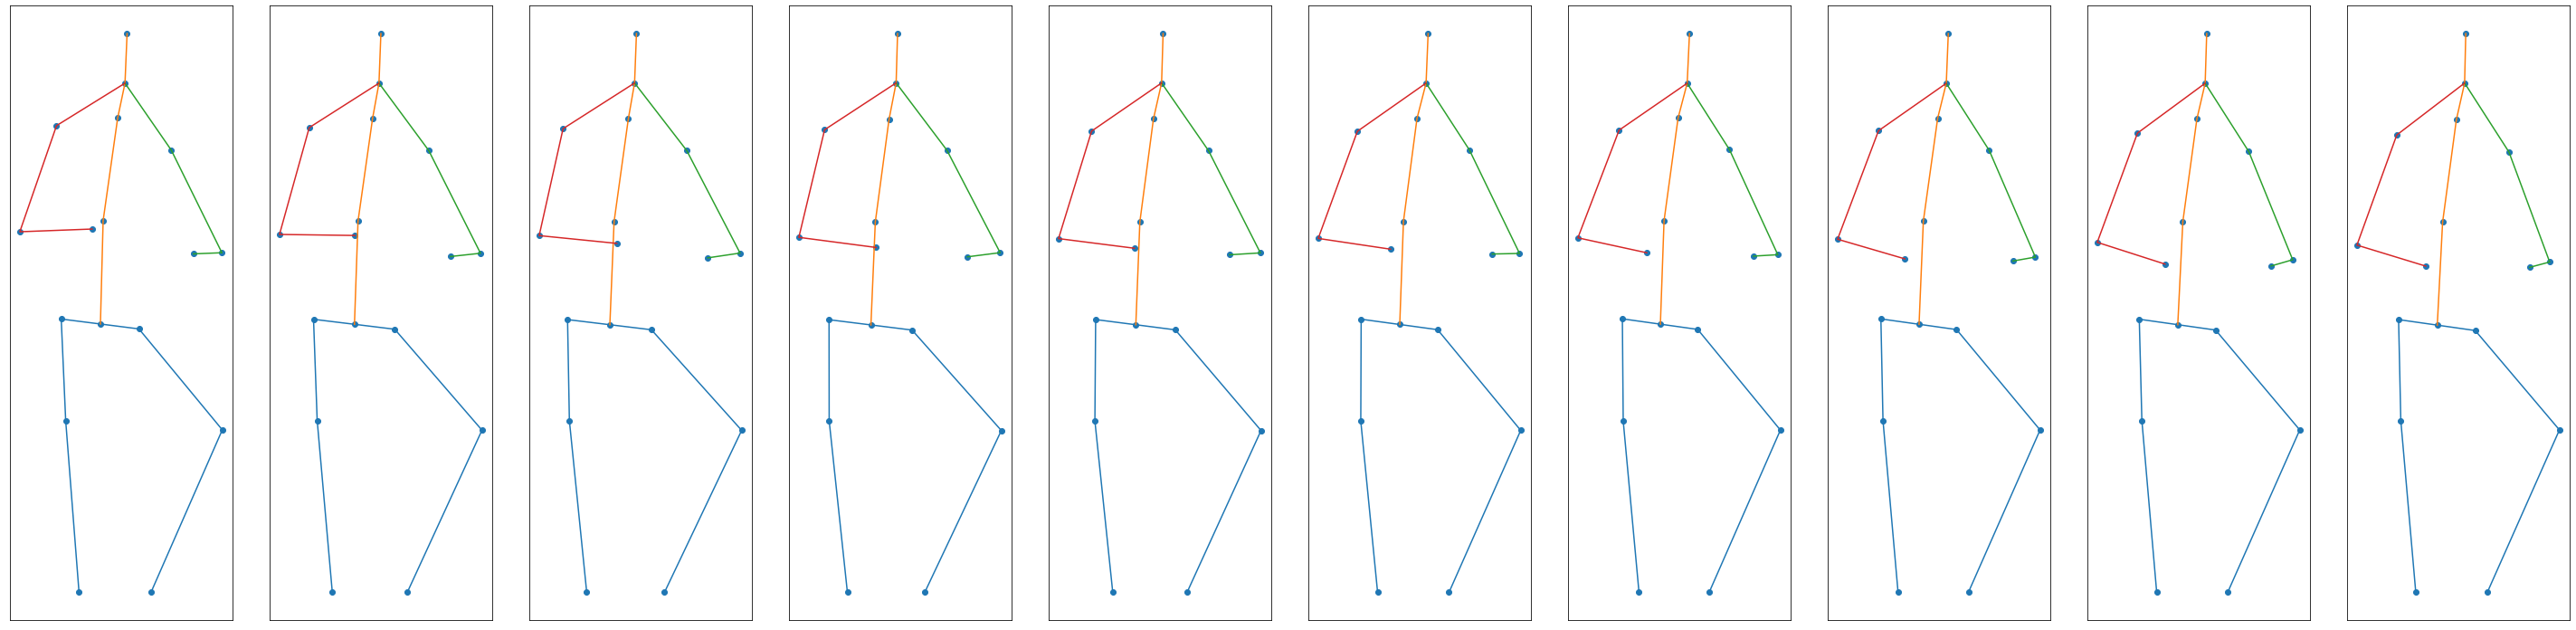

In [252]:
visualize_frames(preprocessed_downsampled_dataY_movable[20000], dynamic_joints_only=True, num_frames_to_visualize=10, save_gif=True, path_to_save='glogenTrue13')

C:\Users\dell\AppData\Local\Temp\ipykernel_17076\4204179701.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


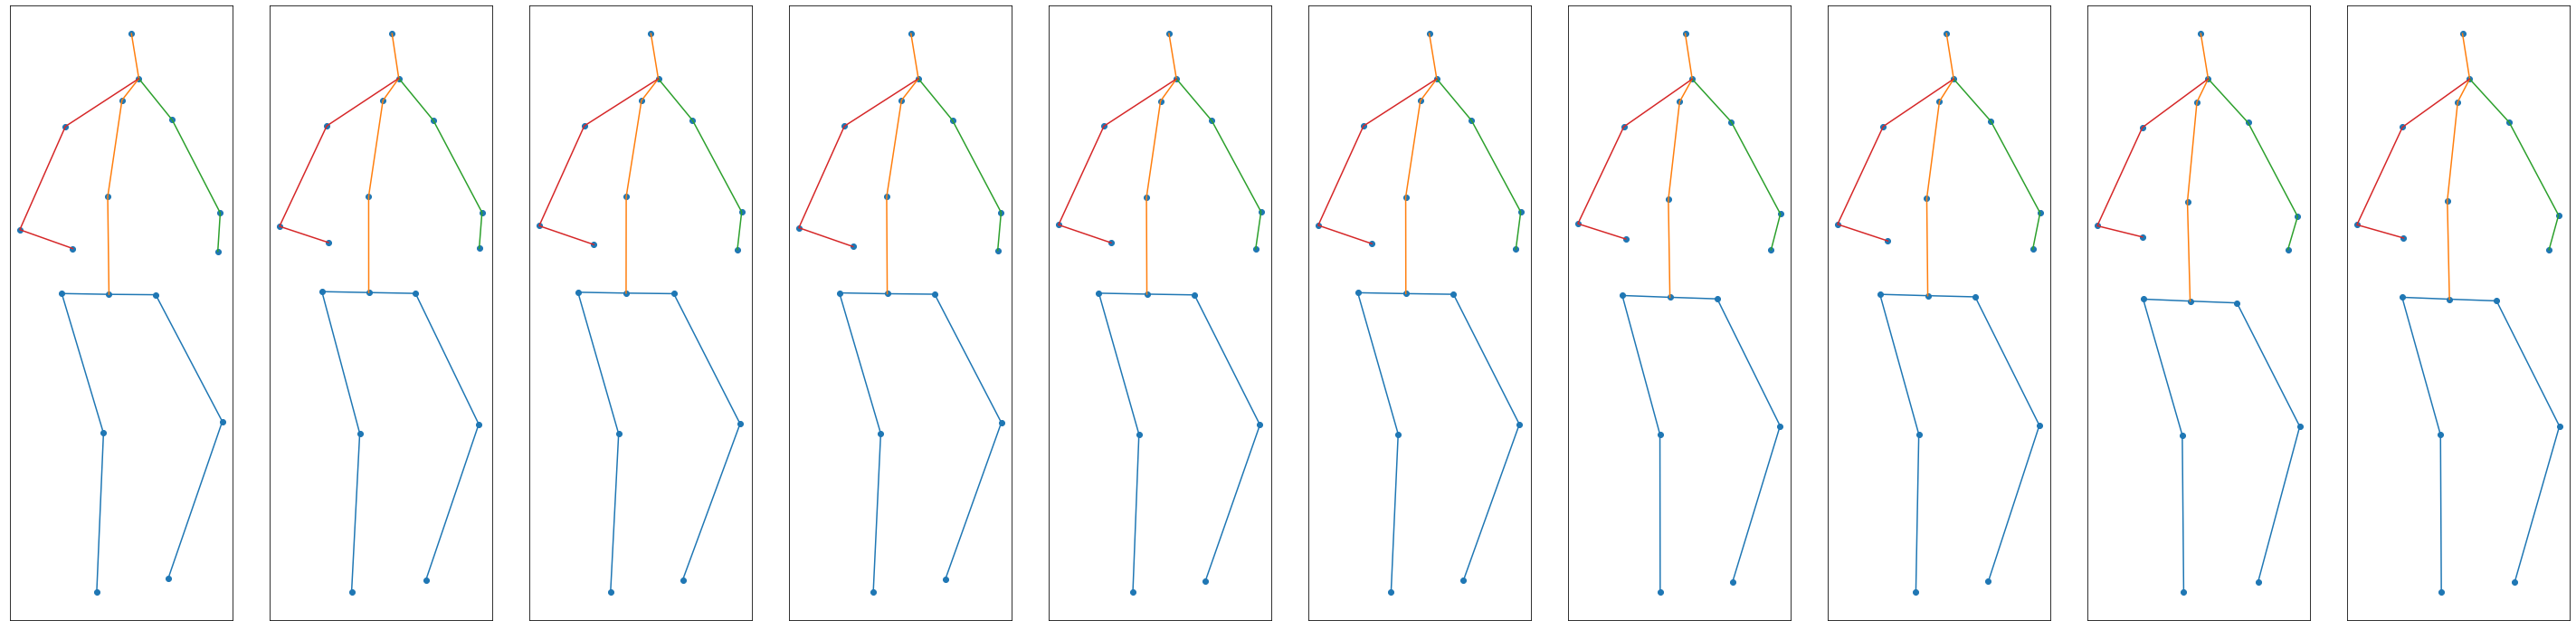

In [250]:
visualize_frames(glocal13_pred[20000], dynamic_joints_only=True, num_frames_to_visualize=10, save_gif=True, path_to_save='glogenPred13')

##### Running Experiment with Downsampled movable datapoints and NPSS evaluation Metric

In [ ]:
history_model14, glocal_model14 = run_experiment(preprocessed_downsampled_dataX_movable, preprocessed_downsampled_dataY_movable, batch_size=20, 
                                                 dropout=0.0, epochs=50, use_mse=True, output_diminsion=34, validation_split=0.0, 
                                                 interpolate_frames = 2, metrics=[Metrics().NPSS, 
                                                                                  tf.keras.losses.mean_absolute_percentage_error])

##### Running Experiment with ONLY Glogen model

In [64]:
history_model15, glocal_model15 = run_experiment(sampled_dataX_short_term, sampled_dataY_short_term, epochs=50, only_glogen=True,
                                                 batch_size=20, use_mse=True, validation_split=0.0, metrics=[tf.keras.losses.mean_absolute_percentage_error,
                                                 Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 35s 8ms/step - loss: 39776.3359 - mean_absolute_percentage_error: 29.9585 - custom_sequence_MMD_loss: 2.1840e-04
Epoch 2/50
3857/3857 [==============================] - 31s 8ms/step - loss: 9833.8223 - mean_absolute_percentage_error: 17.5309 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 3/50
3857/3857 [==============================] - 32s 8ms/step - loss: 9697.2812 - mean_absolute_percentage_error: 17.4329 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 4/50
3857/3857 [==============================] - 33s 8ms/step - loss: 8303.1504 - mean_absolute_percentage_error: 16.2133 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/50
3857/3857 [==============================] - 33s 8ms/step - loss: 6499.2891 - mean_absolute_percentage_error: 14.4827 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/50
3857/3857 [==============================] - 31s 8ms/step - loss: 5836.9399 - mean_absolute_percentage_error: 13.8105 - custom_sequence_MMD_loss: 0.

In [65]:
y_pred = glocal_model15.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 8s 3ms/step
0.004137528429801898


In [67]:
print(Metrics().NPSS(sampled_dataY_short_term, y_pred))

0.004137528429801898


In [66]:
print(Metrics().MPJPE2(sampled_dataY_short_term, y_pred))

762.8843048095703


In [72]:
glocal_model15.save('./glocal_model15')

INFO:tensorflow:Assets written to: ./glocal_model15\assets


INFO:tensorflow:Assets written to: ./glocal_model15\assets


In [161]:
visualize_frames(y_pred[2500, 0:10:2], num_frames_to_visualize=5)

AssertionError: number of frames should be less than or equal to the total frames in the sample

In [77]:
history_model16, glocal_model16 = run_experiment(preprocessed_sampled_dataX_shortterm_movable, preprocessed_sampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                 batch_size=20, output_diminsion=34, interpolate_frames=2, use_mse=True, validation_split=0.0, 
                                                 metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 32s 8ms/step - loss: 46922.1719 - mean_absolute_percentage_error: 33.4939 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
3857/3857 [==============================] - 31s 8ms/step - loss: 19704.2461 - mean_absolute_percentage_error: 21.9666 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
3857/3857 [==============================] - 33s 9ms/step - loss: 19703.8398 - mean_absolute_percentage_error: 21.9666 - custom_sequence_MMD_loss: 0.0500
Epoch 4/50
3857/3857 [==============================] - 31s 8ms/step - loss: 5706.7651 - mean_absolute_percentage_error: 12.6728 - custom_sequence_MMD_loss: 0.0025
Epoch 5/50
3857/3857 [==============================] - 30s 8ms/step - loss: 2821.6384 - mean_absolute_percentage_error: 9.0749 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/50
3857/3857 [==============================] - 31s 8ms/step - loss: 2416.9209 - mean_absolute_percentage_error: 8.3035 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 7

In [78]:
y_pred16 = glocal_model16.predict(preprocessed_sampled_dataX_shortterm_movable)

2411/2411 [==============================] - 9s 3ms/step


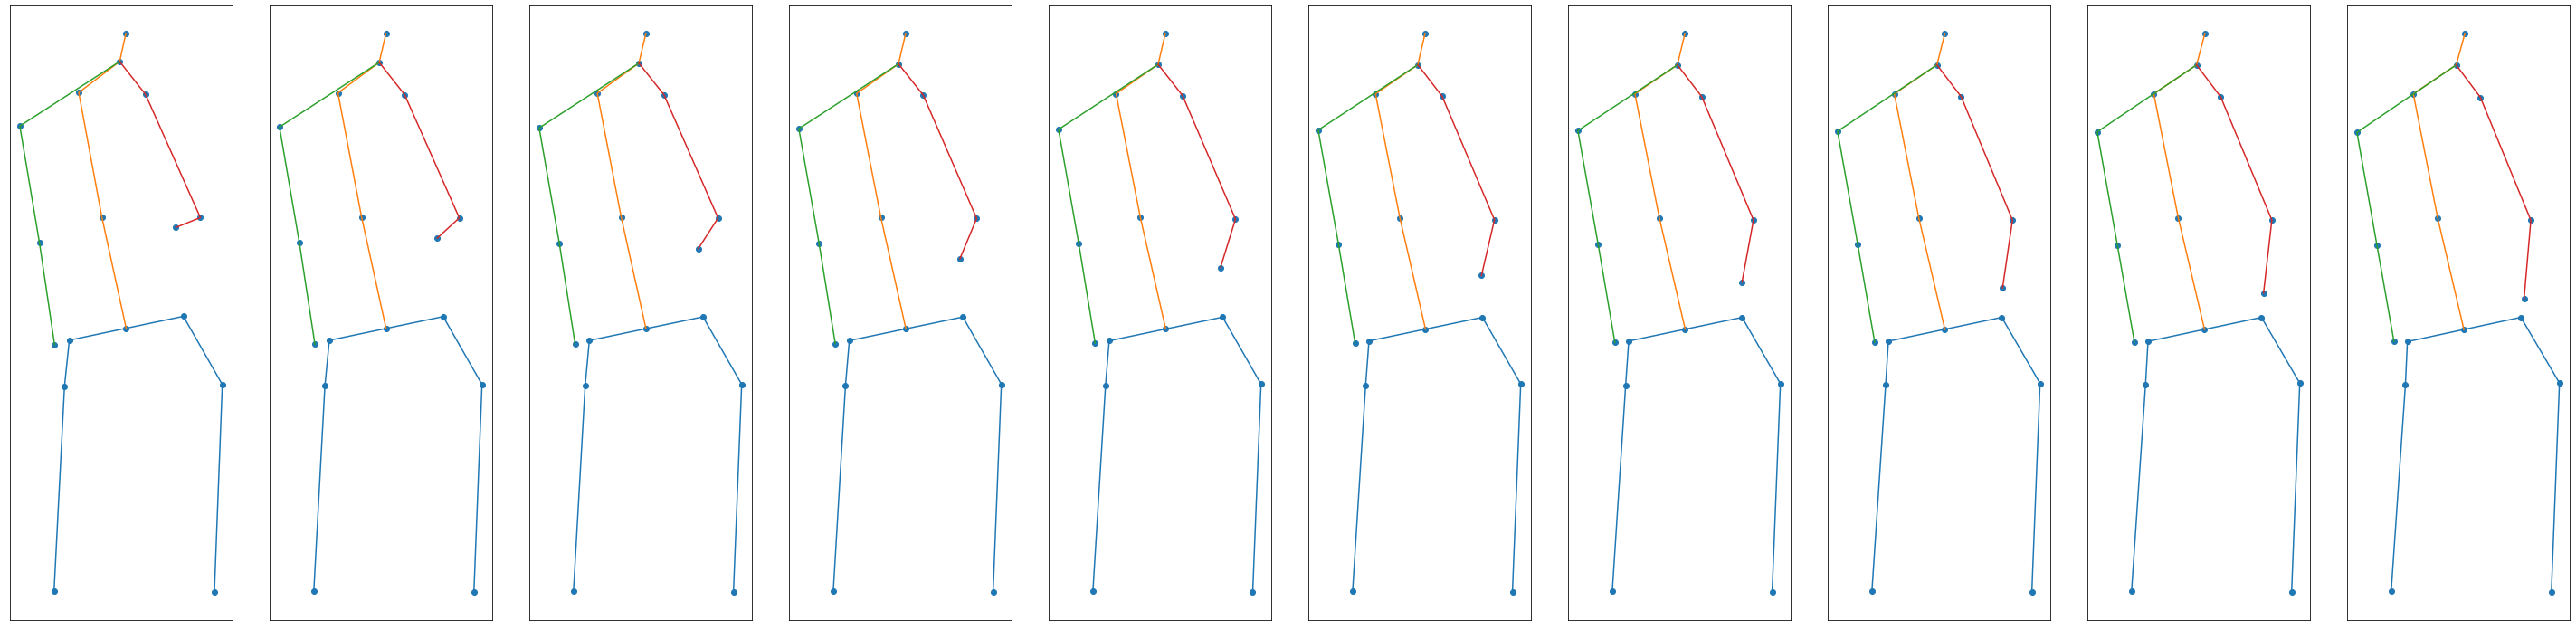

In [207]:
visualize_frames(preprocessed_sampled_dataY_shortterm_movable[4000], dynamic_joints_only=True, num_frames_to_visualize=10, save_gif=False, path_to_save='glogenTrue16')

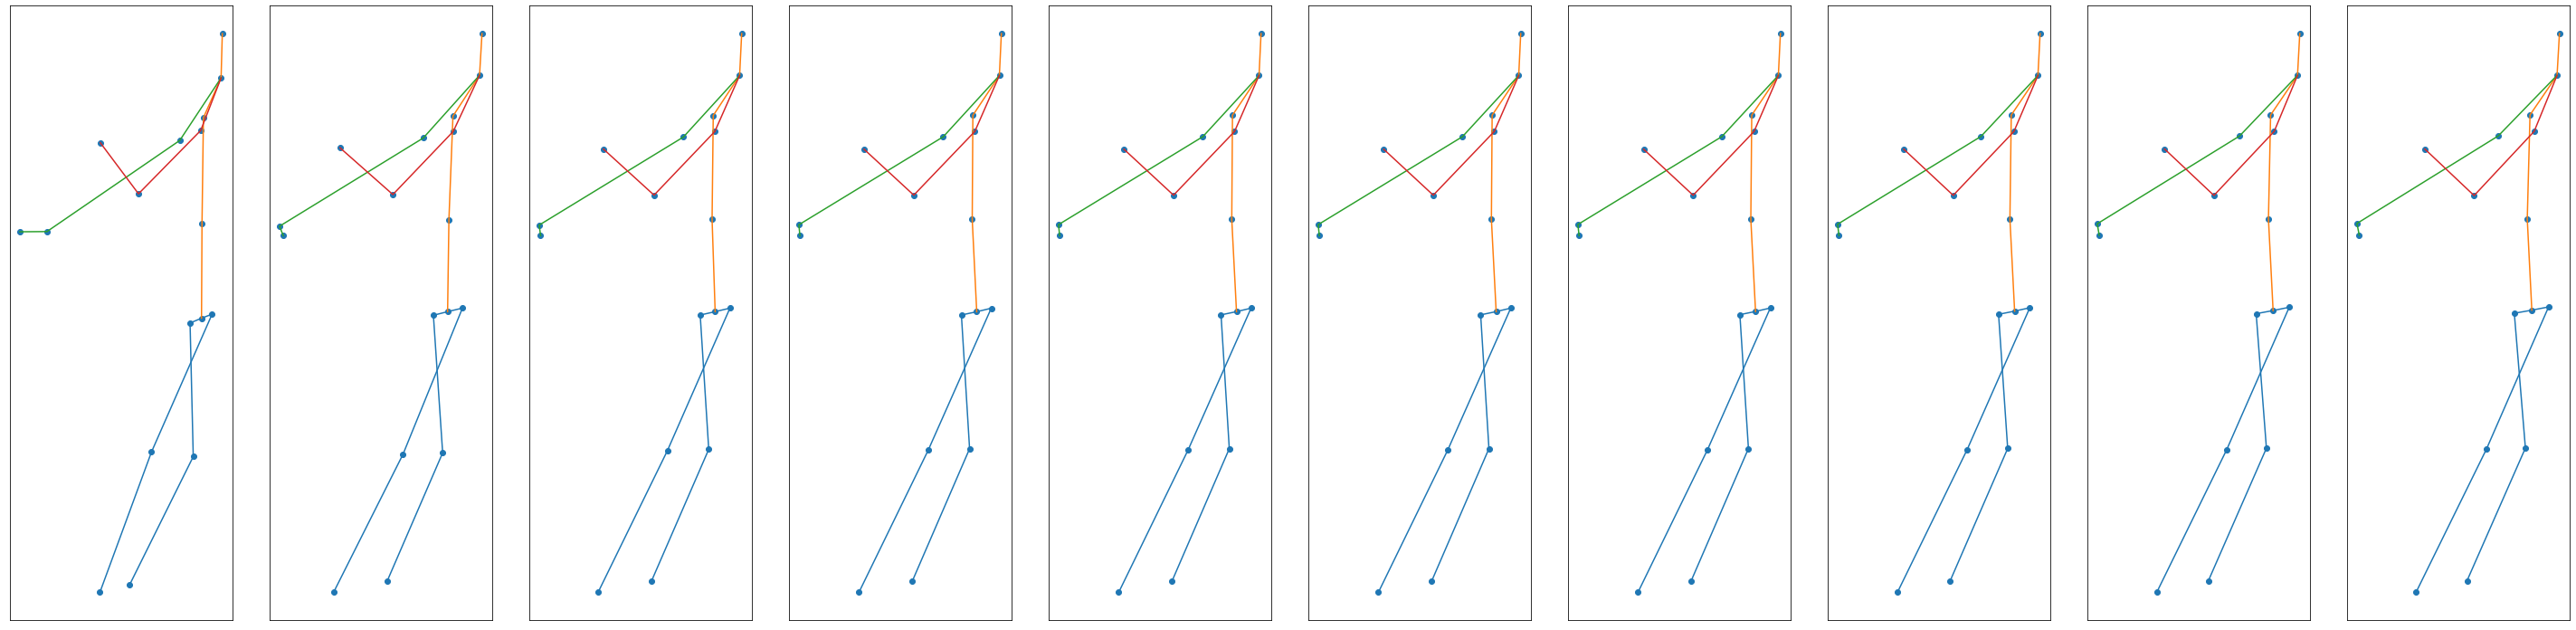

In [208]:
visualize_frames(y_pred16[4000], dynamic_joints_only=True, num_frames_to_visualize=10, save_gif=False, path_to_save='glogenPred16')

In [116]:
print(Metrics().NPSS(preprocessed_sampled_dataY_shortterm_movable, y_pred16))

0.0010556456443385467


In [119]:
print(Metrics().MPJPE2(preprocessed_sampled_dataY_shortterm_movable, y_pred16, number_of_joints=17))

378.5847564697266


In [75]:
glocal_model16.save('./glocal_model16',save_format='tf')

INFO:tensorflow:Assets written to: ./glocal_model16\assets


INFO:tensorflow:Assets written to: ./glocal_model16\assets


In [67]:
y_pred = glocal_model16.predict(preprocessed_sampled_dataX_shortterm_movable)
print(Metrics().NPSS(preprocessed_sampled_dataY_shortterm_movable, y_pred))

2411/2411 [==============================] - 8s 3ms/step
0.22995737958960638


In [120]:
history_model17, glocal_model17 = run_experiment(preprocessed_downsampled_dataX_shortterm_movable, preprocessed_downsampled_dataY_shortterm_movable, epochs=50, only_glogen=True,
                                                 batch_size=20, output_diminsion=34, interpolate_frames=2, use_mse=True, validation_split=0.0, 
                                                 metrics=[tf.keras.losses.mean_absolute_percentage_error, Metrics().custom_sequence_MMD_loss])

Epoch 1/50
3857/3857 [==============================] - 30s 7ms/step - loss: 40369.0391 - mean_absolute_percentage_error: 31.2144 - custom_sequence_MMD_loss: 0.0500
Epoch 2/50
3857/3857 [==============================] - 27s 7ms/step - loss: 12386.8379 - mean_absolute_percentage_error: 19.2122 - custom_sequence_MMD_loss: 0.0500
Epoch 3/50
3857/3857 [==============================] - 28s 7ms/step - loss: 5665.7148 - mean_absolute_percentage_error: 13.0182 - custom_sequence_MMD_loss: 0.0064
Epoch 4/50
3857/3857 [==============================] - 28s 7ms/step - loss: 2770.5281 - mean_absolute_percentage_error: 9.0602 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 5/50
3857/3857 [==============================] - 29s 7ms/step - loss: 2259.5017 - mean_absolute_percentage_error: 8.1018 - custom_sequence_MMD_loss: 0.0000e+00
Epoch 6/50
3857/3857 [==============================] - 29s 7ms/step - loss: 2138.4141 - mean_absolute_percentage_error: 7.8553 - custom_sequence_MMD_loss: 0.0000e+00
Epoch

In [76]:
glocal_model17.save('./glocal_model17',save_format='tf')

INFO:tensorflow:Assets written to: ./glocal_model17\assets


INFO:tensorflow:Assets written to: ./glocal_model17\assets


In [209]:
y_pred17 = glocal_model17.predict(preprocessed_downsampled_dataX_shortterm_movable)

2411/2411 [==============================] - 8s 3ms/step


C:\Users\dell\AppData\Local\Temp\ipykernel_17076\4204179701.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


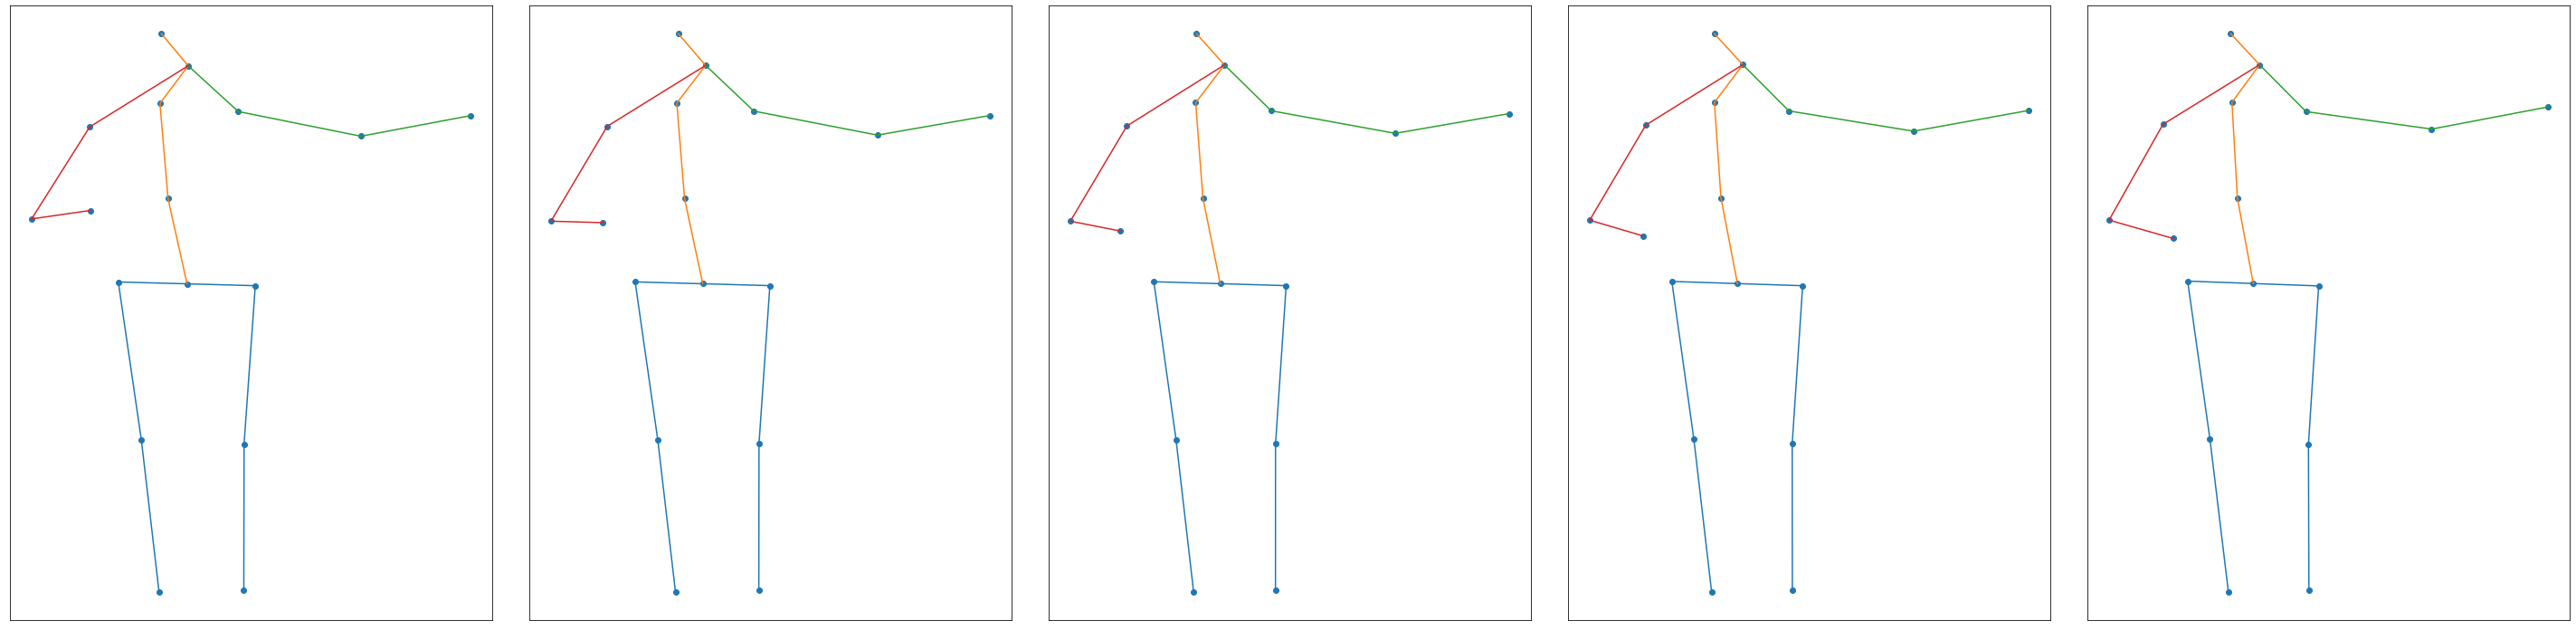

In [224]:
visualize_frames(preprocessed_downsampled_dataY_shortterm_movable[100], dynamic_joints_only=True, num_frames_to_visualize=5, save_gif=True, path_to_save='glogenTrue17')

C:\Users\dell\AppData\Local\Temp\ipykernel_17076\4204179701.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


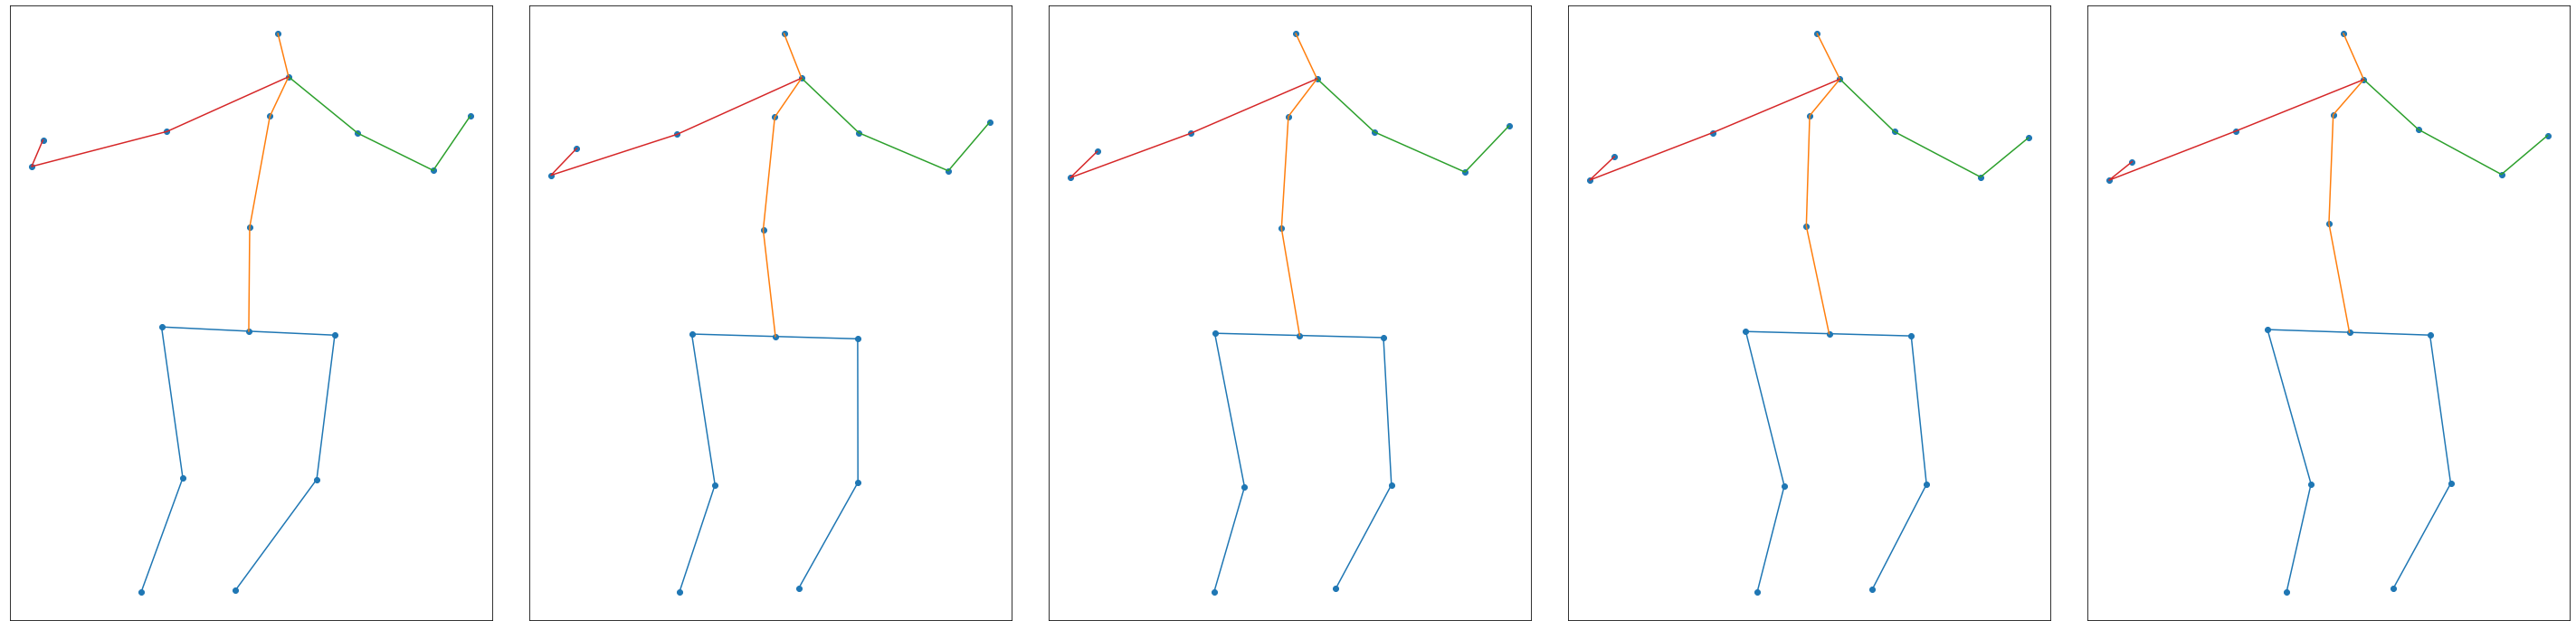

In [225]:
visualize_frames(y_pred17[100], dynamic_joints_only=True, num_frames_to_visualize=5, save_gif=True, path_to_save='glogenPred17')

In [122]:
print(Metrics().NPSS(preprocessed_downsampled_dataY_shortterm_movable, y_pred))

0.0007349017665109266


In [227]:
print(Metrics().MPJPE2(preprocessed_downsampled_dataY_shortterm_movable, y_pred))

ValueError: cannot reshape array of size 13113800 into shape (32,2)

In [136]:
history_model17.history.keys()

dict_keys(['loss', 'mean_absolute_percentage_error', 'custom_sequence_MMD_loss'])

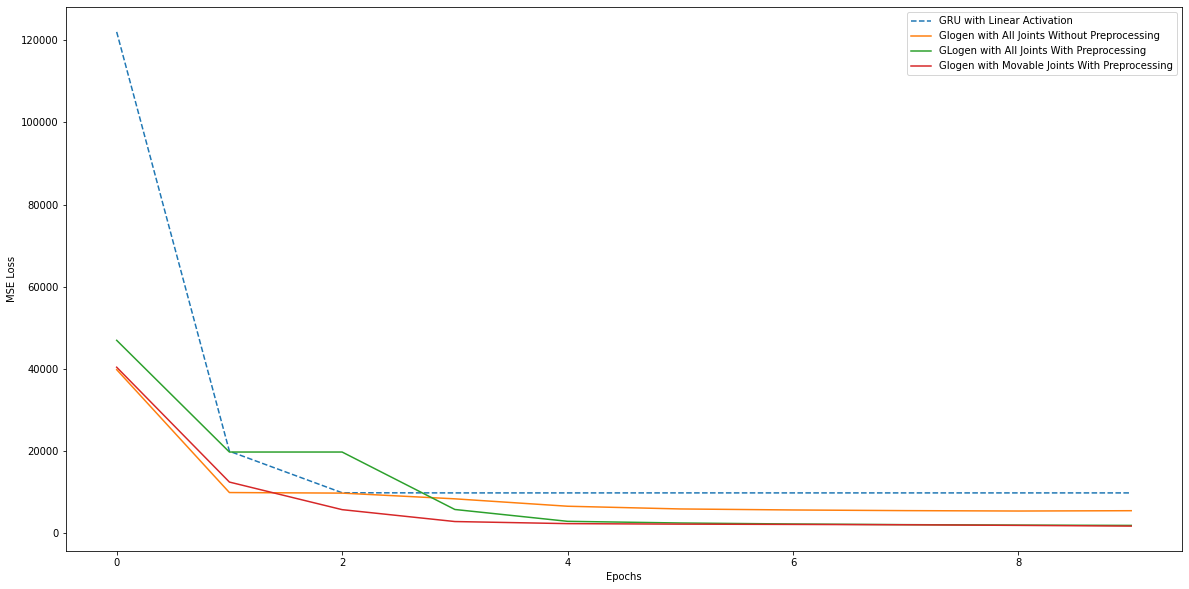

In [146]:
from cProfile import label

from matplotlib.lines import lineStyles


fig = plt.figure(figsize=(20,10))

plt.plot(history_simple_RNN6.history['loss'][:10], linestyle='--', label='GRU with Linear Activation')

plt.plot(history_model15.history['loss'][:10], label='Glogen with All Joints Without Preprocessing')
plt.plot(history_model16.history['loss'][:10], label='GLogen with All Joints With Preprocessing')
plt.plot(history_model17.history['loss'][:10], label='Glogen with Movable Joints With Preprocessing')

plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.show()

In [80]:
def saveGlocalNetWeights(model, file_path) :
    """
    A function to save all layers weights except for interpolation layer
    """
    model_layers = np.array([], dtype=object)
    for layer in model.layers :
        model_layers = np.append(model_layers, layer.get_weights())
    np.save(file_path, model_layers)

In [81]:
def createGlocalNetFromFile(model : GlocalNet, model_weights_file, sample_input, output_diminsions=64,
interpolation_frames=2, dense_activation="relu") :
    """
    function use presaved weights from file_path(model_weights_file) and uses sample_input to 
    build the model
    """
    #Create an empty glocalNet model
    model = GlocalNet(exclude_locgen=model.exclude_locgen, output_diminsion=output_diminsions,
     interpolation_frames=interpolation_frames, dense_activation=dense_activation)
    model_weights = np.load(model_weights_file, allow_pickle=True)
    model(sample_input)
    if(model.exclude_locgen) :
        #Setting Glogen layers
        layer0_weights = model_weights[:3]
        layer1_weights = model_weights[3:6]
        layer4_weights = model_weights[6:]
        #Setting the Glogen layers
        model.layers[0].set_weights(layer0_weights)
        model.layers[1].set_weights(layer1_weights)
        model.layers[4].set_weights(layer4_weights)
    else :    
        #Setting Glogen layers
        layer0_weights = model_weights[:3]
        layer1_weights = model_weights[3:6]
        layer4_weights = model_weights[12:14]
        #Setting Locgen layers
        layer2_weights = model_weights[6:9]
        layer3_weights = model_weights[9:12]
        layer6_weights = model_weights[14:]
            #Building the model to be able to set the layers' weights
        model(sample_input)
        #Setting the Glogen layers
        model.layers[0].set_weights(layer0_weights)
        model.layers[1].set_weights(layer1_weights)
        model.layers[4].set_weights(layer4_weights)
        #Setting locgen layers
        model.layers[2].set_weights(layer2_weights)
        model.layers[3].set_weights(layer3_weights)
        model.layers[6].set_weights(layer6_weights)
        
    return model

In [83]:
saveGlocalNetWeights(glocal_model16, 'glocal_model16')

c:\Users\dell\anaconda3\envs\srp\lib\site-packages\numpy\core\fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [84]:
saveGlocalNetWeights(glocal_model17, 'glocal_model17')

c:\Users\dell\anaconda3\envs\srp\lib\site-packages\numpy\core\fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


In [82]:
saveGlocalNetWeights(glocal_model15, 'glocal_model15')

c:\Users\dell\anaconda3\envs\srp\lib\site-packages\numpy\core\fromnumeric.py:1822: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asanyarray(a).ravel(order=order)


## Visualization

In [ ]:
predictions_simple_RNN1 = simple_RNN1.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 10s 4ms/step


In [ ]:
predictions_simple_RNN2 = simple_RNN2.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 8s 3ms/step


In [ ]:
predictions_simple_RNN4 = simple_RNN4.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 6s 2ms/step


In [ ]:
predictions_simple_RNN5 = simple_RNN5.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 10s 4ms/step


In [ ]:
predictions_simple_RNN6 = simple_RNN6.predict(sampled_dataX_short_term)

2411/2411 [==============================] - 13s 5ms/step


In [ ]:
predictions = glocal_model1.predict(sampled_dataX_all)

798/798 [==============================] - 112s 132ms/step


In [ ]:
import viz

AttributeError: 'AxesSubplot' object has no attribute 'set_xlim3d'

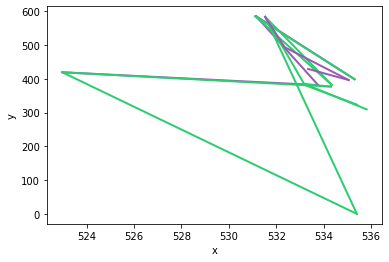

In [ ]:
fig = plt.figure()
ax = plt.gca()

lcolor = '#9b59b6'
rcolor = '#2ecc71'

I   = np.array([1,2,3,1,7,8,1, 13,14,15,14,18,19,14,26,27])-1
J   = np.array([2,3,4,7,8,9,13,14,15,16,18,19,20,26,27,28])-1
LR  = np.array([1,1,1,0,0,0,0, 0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=bool)

plots = []
for i in np.arange( len(I) ):
  x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
  y = np.array( [vals[I[i], 1], vals[J[i], 1]] )
  plots.append(ax.plot(x, y, lw=2, c=lcolor if LR[i] else rcolor))

ax.set_xlabel("x")
ax.set_ylabel("y")

# Plot the prediction
for i in range(predictions.shape[0]):
    vals = np.reshape(predictions[i,:], (32, -1) )

    for i in np.arange( len(I) ):
      x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
      y = np.array( [vals[I[i], 1], vals[J[i], 1]] )
      
      plots[i][0].set_xdata(x)
      plots[i][0].set_ydata(y)
      
      plots[i][0].set_color(lcolor if LR[i] else rcolor)

    r = 750
    xroot, yroot = vals[0,0], vals[0,1]
    ax.set_xlim3d([-r+xroot, r+xroot])
    ax.set_ylim3d([-r+yroot, r+yroot])

    ax.set_aspect('equal')
    
    plt.show(block=False)
    fig.canvas.draw()
    plt.pause(0.01)

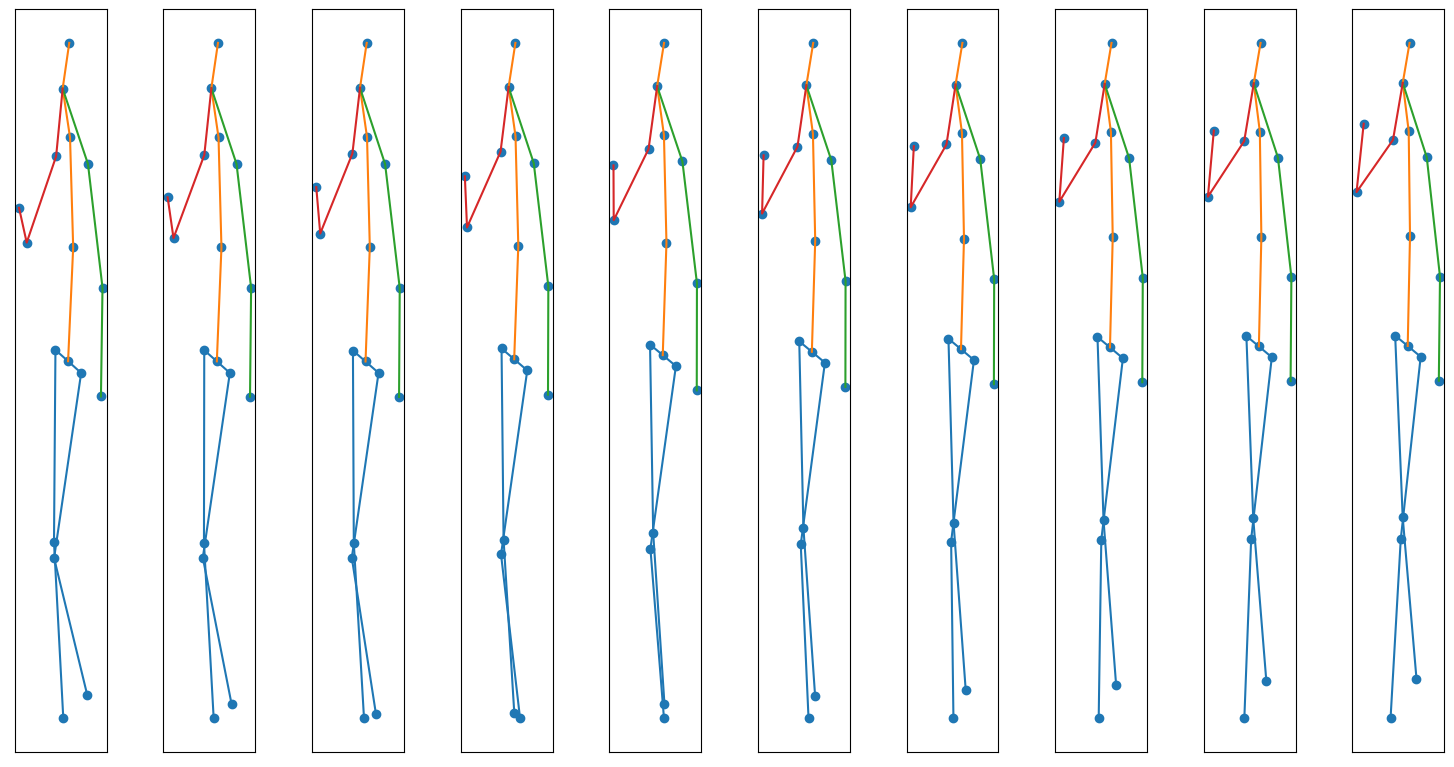

In [ ]:
visualize_frames(sampled_dataY_short_term[50000])

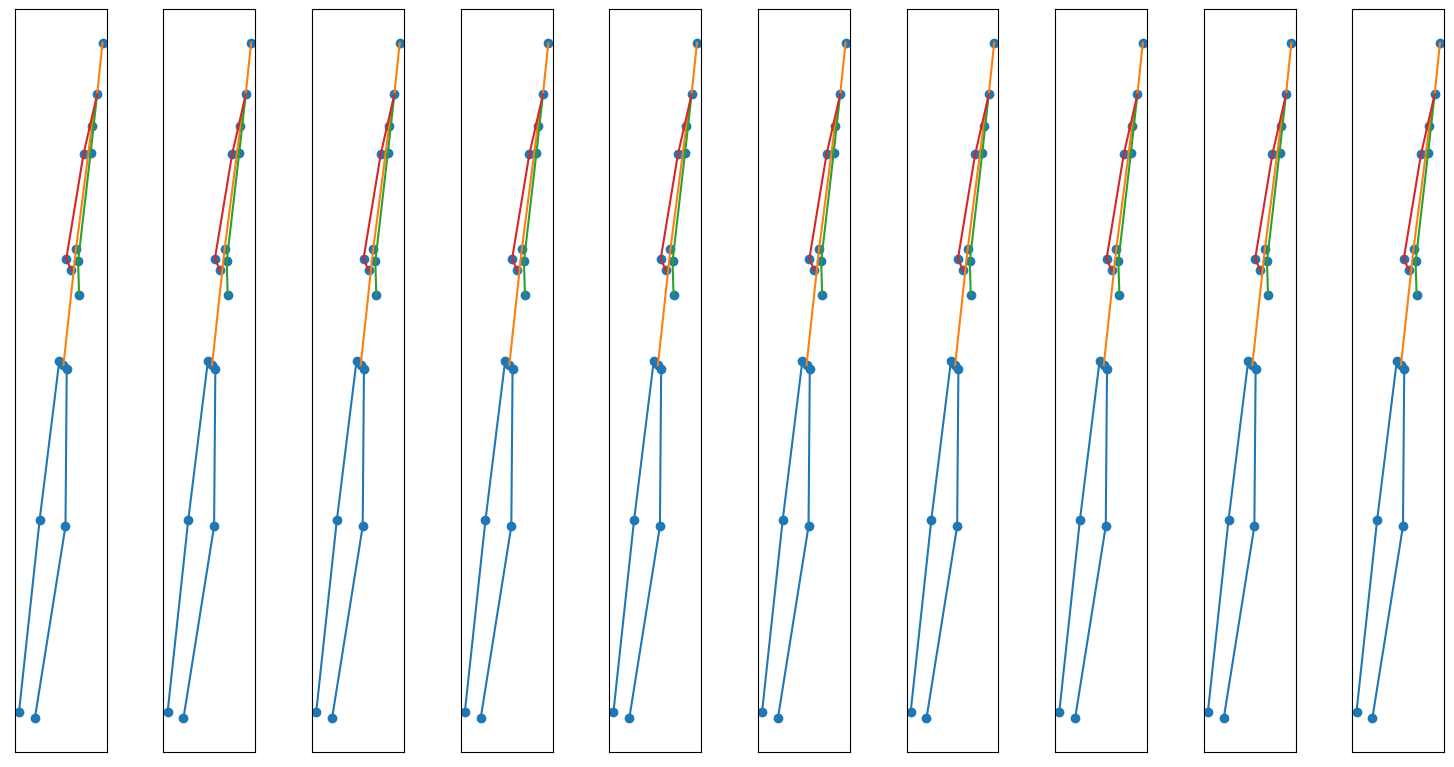

In [ ]:
visualize_frames(predictions_simple_RNN6[5000])

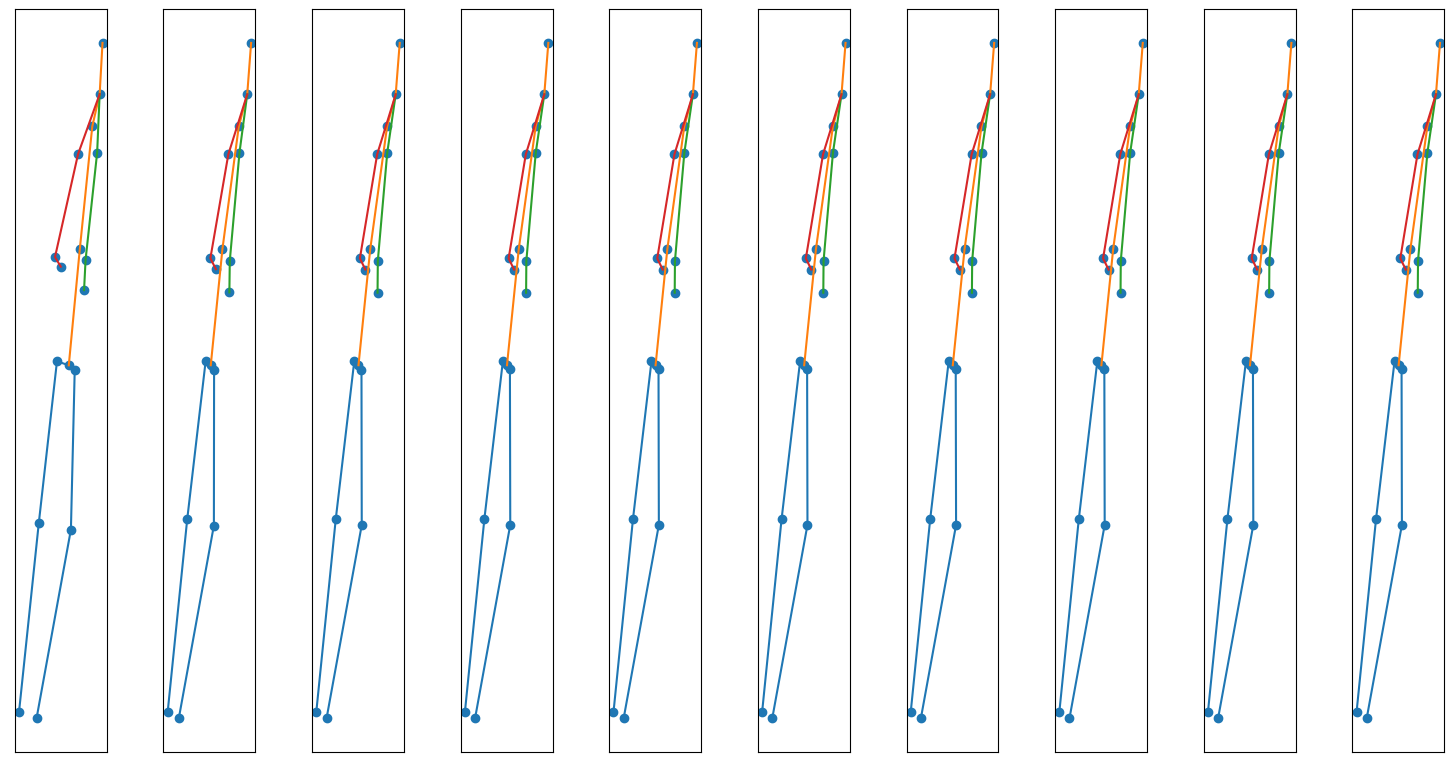

In [ ]:
visualize_frames(predictions_simple_RNN5[0])

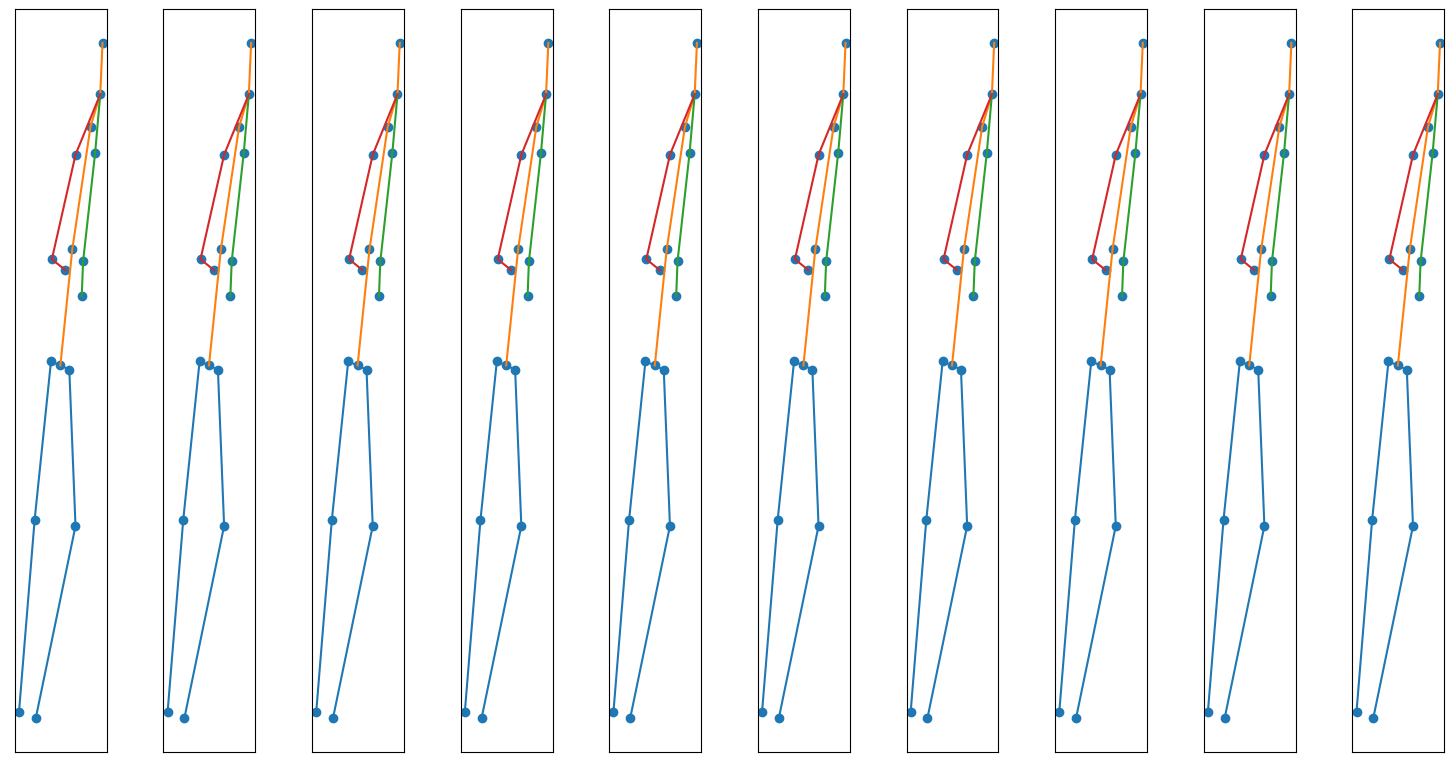

In [ ]:
visualize_frames(predictions_simple_RNN4[50000])

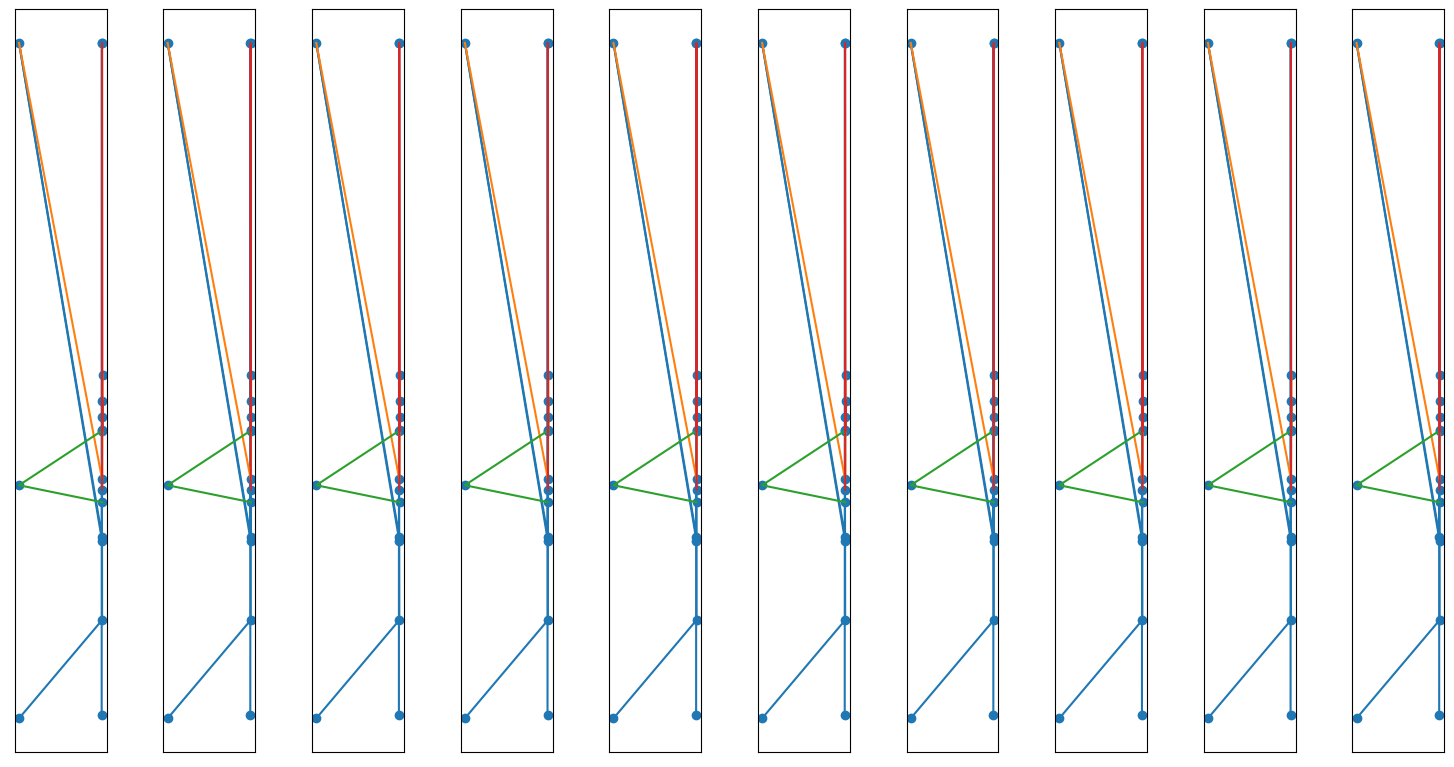

In [ ]:
visualize_frames(predictions_simple_RNN2[1000])

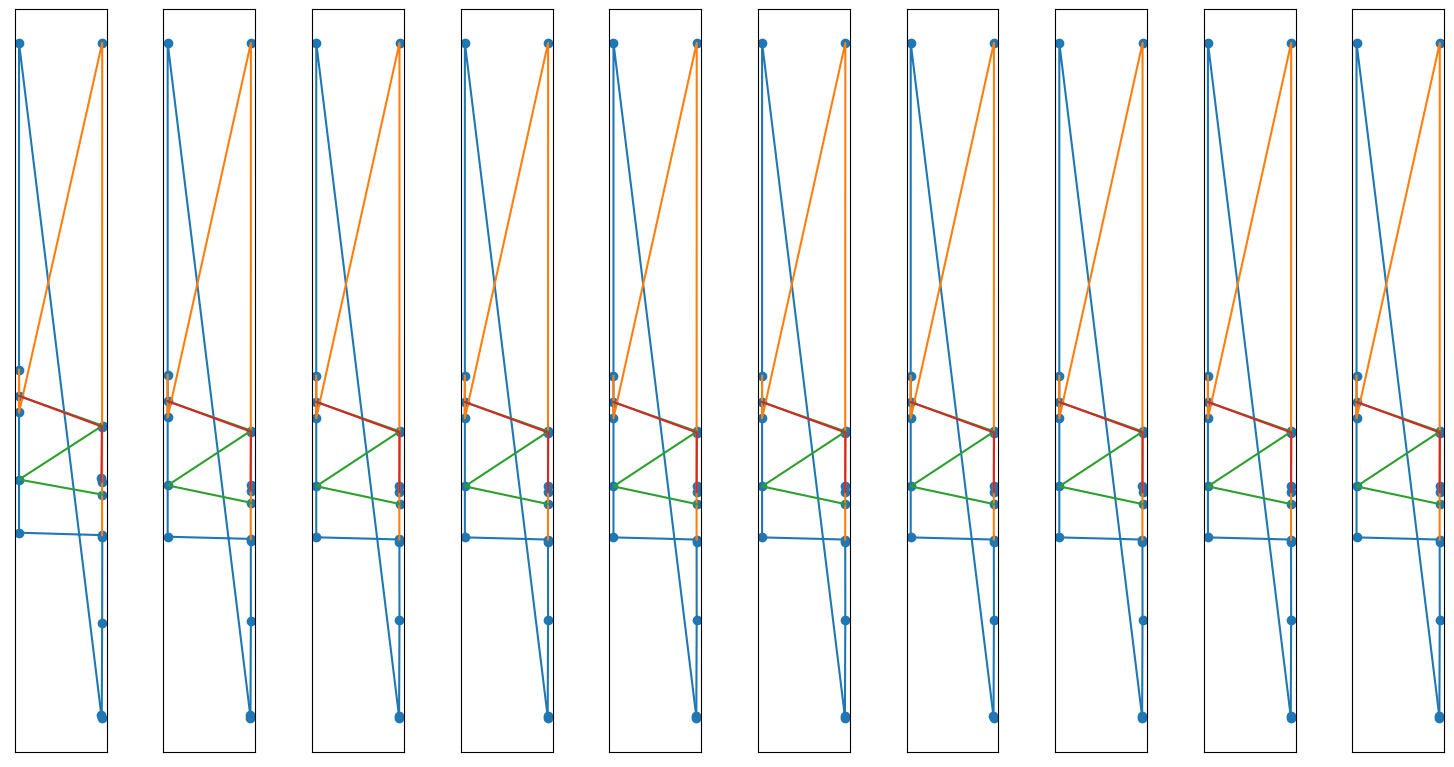

In [ ]:
visualize_frames(predictions_simple_RNN1[1000])

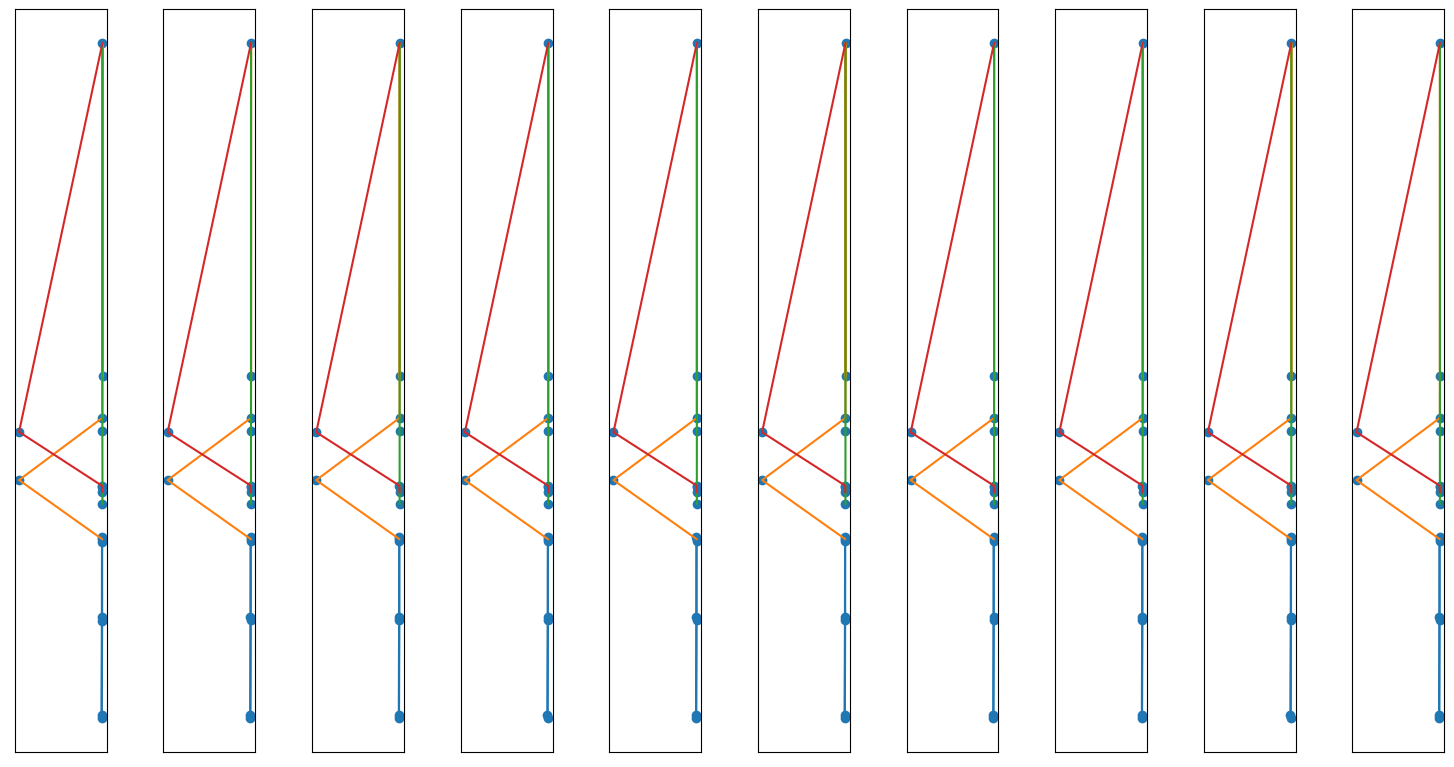

In [ ]:
visualize_frames(predictions[1300, 0:20:2], num_frames_to_visualize=10)

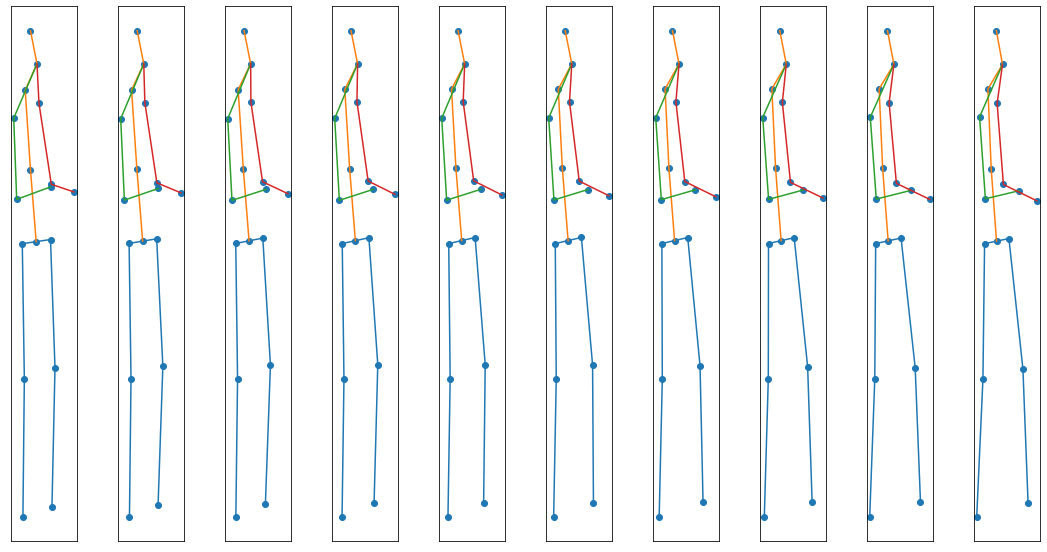

In [ ]:
visualize_frames(preprocessed_downsampled_dataX[1300], num_frames_to_visualize=10)

In [ ]:
print(len(tf.config.list_physical_devices('GPU')))

1


## Saving models

In [ ]:
glocal_interpolation_only.save('minterpolation_only_downsampled20',save_format='tf')

# References

[1] https://github.com/una-dinosauria/3d-pose-baseline/blob/master/src/data_utils.py

[2] Gopalakrishnan, Anand, et al. "A neural temporal model for human motion prediction." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2019

[3] https://github.com/cr7anand/neural_temporal_models